In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import Modules.chain_methods as cm
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib

%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
importlib.reload(cm)
np.set_printoptions(linewidth=300, formatter={'float': '{:.4f}'.format})

In [2]:
cases = []
g_Φ = 0
g_c = 1 # can be any        
g_q = g_c
 
δ= 0
cases.append([δ, g_Φ, g_c, g_q])

δ= 2 *  g_c  
cases.append([δ, g_Φ, g_c, g_q])

δ= 4 * g_c 
cases.append([δ, g_Φ, g_c, g_q])

δ= 8 * g_c
cases.append([δ, g_Φ, g_c, g_q])


cases_titles = ['$\delta/g=0$','$\delta/g=2$','$\delta/g=4$','$\delta/g=8$']

In [3]:
# Bloch sphere for plots
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

In [4]:
# k_values = np.linspace(-np.pi, np.pi, 101)
k_values = np.linspace(0, 2*np.pi, 101)
H_k  = np.zeros([len(cases), len(k_values), 2, 2], dtype = 'complex')
E_k  = np.zeros([len(cases), len(k_values), 2])

winding_number =np.zeros(len(cases))
σx, σy, σz = sq_ext.pauli_matrices()

for i, case in enumerate(cases):
    δ, g_Φ, g_c, g_q = case
    winding_number[i] = cm.winding_number_angle(lambda k: cm.momentum_H_unit_cell_boson_ladder(δ, g_Φ, g_c, g_q, k))

    for j, k in enumerate(k_values):
        H_k[i,j] = cm.momentum_H_unit_cell_boson_ladder(δ, g_Φ, g_c, g_q, k)
        E_k[i,j] = np.linalg.eigh(H_k[i,j])[0]


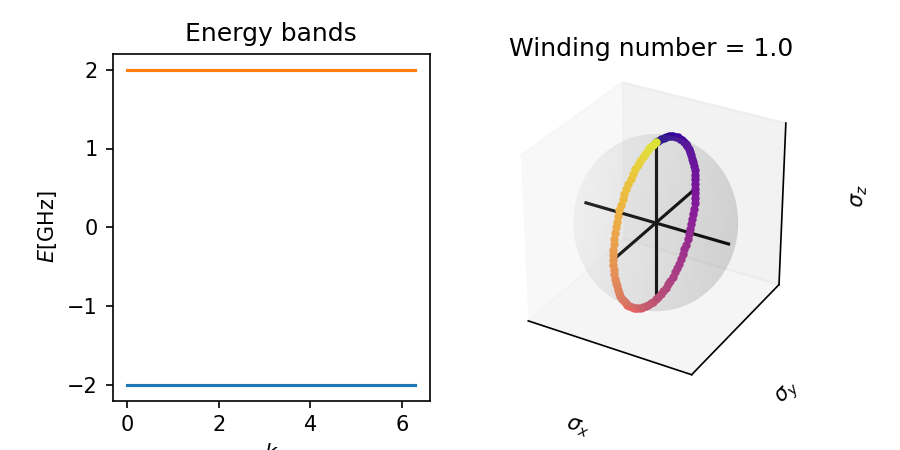

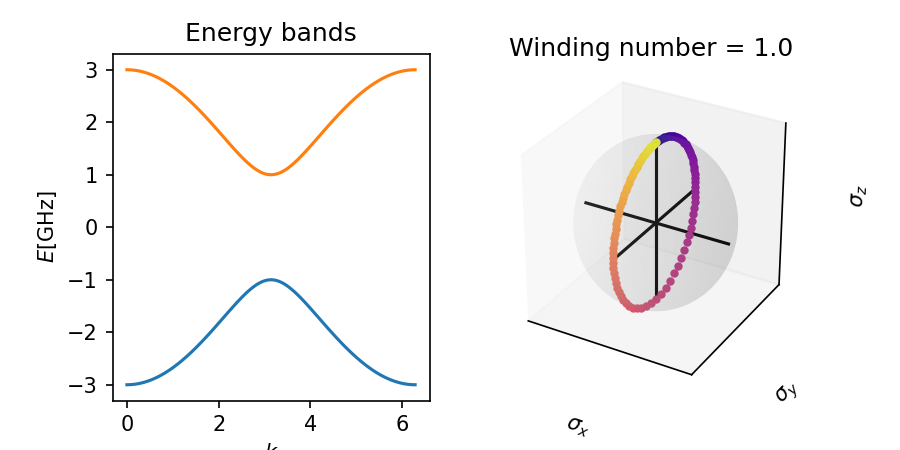

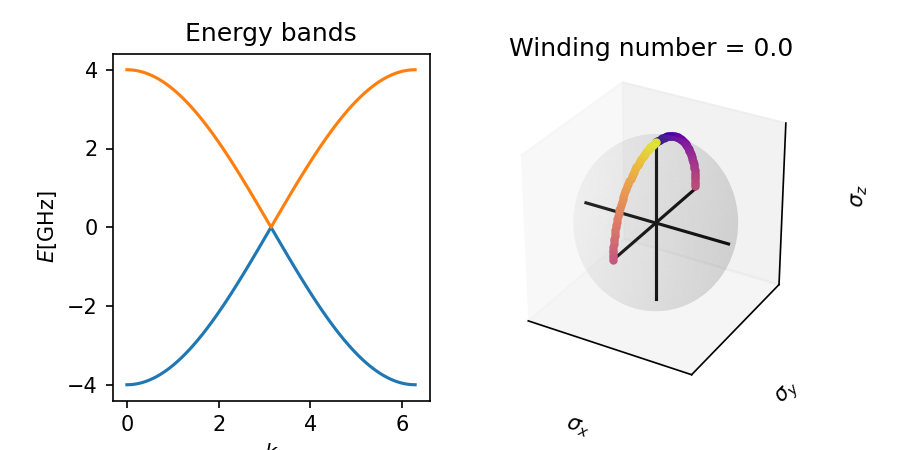

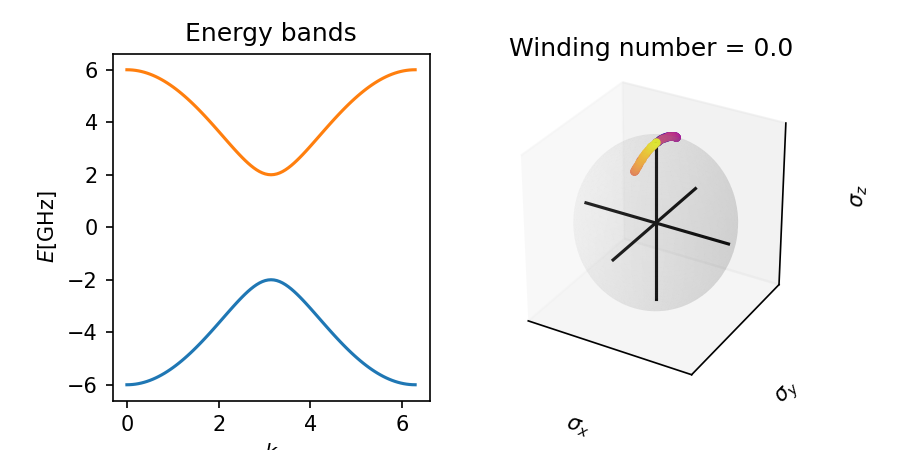

In [5]:
colors = figs.generate_colors_from_colormap(len(k_values), 'plasma')

for i, case in enumerate(cases): 
    fig = plt.figure(figsize=(6, 3), dpi=150)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title("Energy bands")
    ax2 = fig.add_subplot(1,2, 2, projection='3d')
    ax2.set_title(f"Winding number = {winding_number[i]}")
    
    ax = [ax1, ax2]
    
    #Energy bands
    ax[0].plot(k_values, E_k[i, :, 0])
    ax[0].plot(k_values, E_k[i, :, 1])
    ax[0].set_ylabel(r'$E$[GHz]')
    ax[0].set_xlabel('$k$')
        
    #Trajectory in bloch sphere
    ax[1].plot_surface(x_sphere, y_sphere, z_sphere, color='lightgray', alpha=0.1)
    ax[1].plot([-1,1], [0,0], [0,0],'k')
    ax[1].plot([0,0],[-1,1],  [0,0],'k')
    ax[1].plot( [0,0], [0,0],[-1,1],'k')
    
    hx, hy, hz  = [ np.zeros(len(k_values)) for _ in range(3)]
    for j in range(len(k_values)):
        _, hx[j], hy[j], hz[j] =  sq_ext.decomposition_in_pauli_2x2(H_k[i,j])
        
    norm = np.sqrt(hx**2 + hy**2 + hz**2)
    hx /= norm
    hy /= norm
    hz /= norm
    
    for j in range(len(k_values)):
        ax[1].plot(hx[j], hy[j], hz[j],'.', color=colors[j])

    ax[1].set_xlabel(r'$\sigma_x$')
    ax[1].set_ylabel(r'$\sigma_y$')
    ax[1].set_zlabel(r'$\sigma_z$')
    ax[1].set_box_aspect([1,1,1])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_zticks([])


In [6]:
plt.close('all')

In [7]:
δ, g_Φ, g_c, g_q = cases[1]
δ, g_Φ, g_c, g_q

(2, 0, 1, 1)

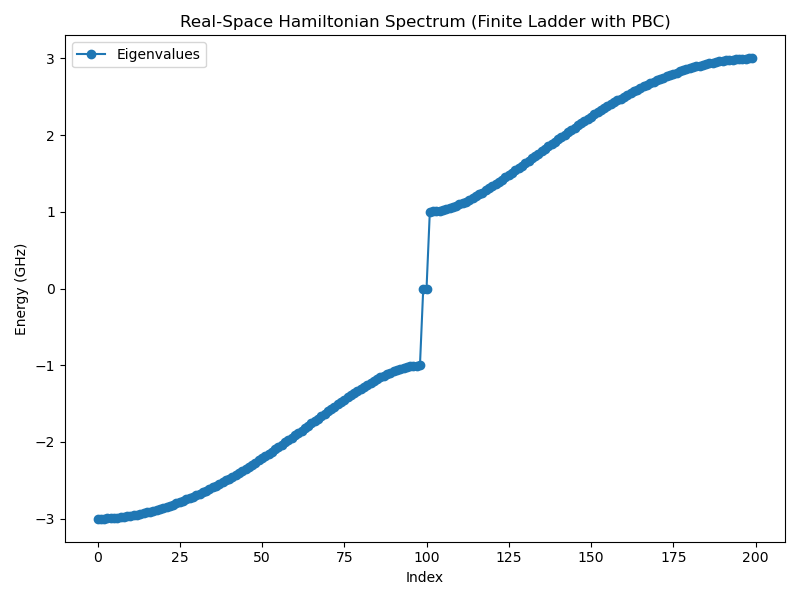

In [8]:

omega_c =  -δ/2 # Onsite frequency for mode a (resonator)
omega_q =  δ/2 # Onsite frequency for mode b (qubit)

# g_c = g_q * 200

# Number of unit cells
N =100

# Total Hilbert space dimension: 2 modes per cell
dim = 2 * N

# Initialize the Hamiltonian matrix (complex valued)
H_real = cm.real_H_unit_cell_boson_ladder(omega_c, omega_q, g_Φ, g_c, g_q, N)

# Diagonalize the Hamiltonian
eigvals, eigvecs = np.linalg.eig(H_real)
eigvals = np.sort(np.real(eigvals))  # sorting eigenvalues

# Plot the eigenvalue spectrum
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(np.arange(dim), eigvals, 'o-', label='Eigenvalues')
ax.set_xlabel('Index')
ax.set_ylabel('Energy (GHz)')
ax.set_title('Real-Space Hamiltonian Spectrum (Finite Ladder with PBC)')
ax.legend()
fig.tight_layout()


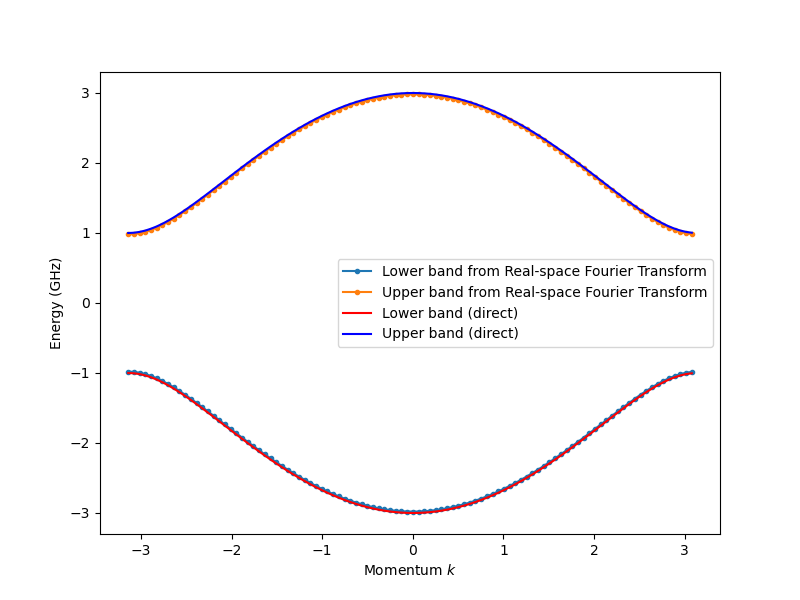

In [9]:
# Create the Fourier transform matrix F for the cell indices (N x N)
F = np.zeros((N, N), dtype=np.complex128)
for n in range(N):
    for m in range(N):
        k = 2 * np.pi * m / N  # allowed discrete momentum
        F[n, m] = np.exp(1j * k * n) / np.sqrt(N)

# Build the full Fourier transform matrix U for the 2N-dimensional space:
# U = F \otimes I_2
I2 = np.eye(2, dtype=np.complex128)
U = np.kron(F, I2)

# Transform the real-space Hamiltonian into momentum space
H_mom = U.conj().T @ H_real @ U

# Now, H_mom should be block-diagonal.
# Extract the 2x2 blocks for each momentum value:
Hk_blocks = np.zeros((N, 2, 2), dtype=np.complex128)
eigvals_mom = np.zeros((N, 2))
for m in range(N):
    # The block corresponding to momentum k = 2pi*m/N is:
    Hk_blocks[m] = H_mom[2*m:2*m+2, 2*m:2*m+2]
    eigvals = np.linalg.eigvals(Hk_blocks[m])
    eigvals_mom[m] = np.sort(np.real(eigvals)) #|- np.mean(np.real(eigvals))

# Construct corresponding k values
k_vals = np.array([2*np.pi*m/N for m in range(N)])#-np.pi

# Plot the momentum-space bands from the block diagonalization
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(k_vals-np.pi, eigvals_mom[:, 0], '.-', label='Lower band from Real-space Fourier Transform')
ax.plot(k_vals-np.pi, eigvals_mom[:, 1], '.-', label='Upper band from Real-space Fourier Transform')
ax.set_xlabel('Momentum $k$')
ax.set_ylabel('Energy (GHz)')

# For comparison, we also construct the momentum-space Hamiltonian directly:
E_band1 = np.zeros(N)
E_band2 = np.zeros(N)
for m, k in enumerate(k_vals):
    M_k = np.array([[omega_c + 2*g_c*np.cos(k), g_Φ + 1j*2*np.sqrt(g_c * g_q) *np.sin(k)],
                    [g_Φ - 1j*2*np.sqrt(g_c * g_q) *np.sin(k), omega_q - 2*g_q*np.cos(k)]])
    # M_k = cm.momentum_H_unit_cell_boson_ladder(δ, g_Φ, g_c, g_q, k)

    eigvals = np.linalg.eigvals(M_k)
    eigvals = np.sort(np.real(eigvals))
    E_band1[m] = eigvals[0]
    E_band2[m] = eigvals[1]

ax.plot(k_vals-np.pi, E_band1, 'r-', label='Lower band (direct)')
ax.plot(k_vals-np.pi, E_band2, 'b-', label='Upper band (direct)')

ax.legend()

In [10]:
# Assume you already have H_real and N, dim, etc., from your existing code.

# 1) Diagonalize H_real
eigvals_real, eigvecs_real = np.linalg.eig(H_real)
eigvals_real = np.real(eigvals_real)
idx_sort = np.argsort(eigvals_real)
eigvals_sorted = eigvals_real[idx_sort]
eigvecs_sorted = eigvecs_real[:, idx_sort]  # columns are eigenvectors

Chosen eigenvalue ~ -2.7338617545086673e-15


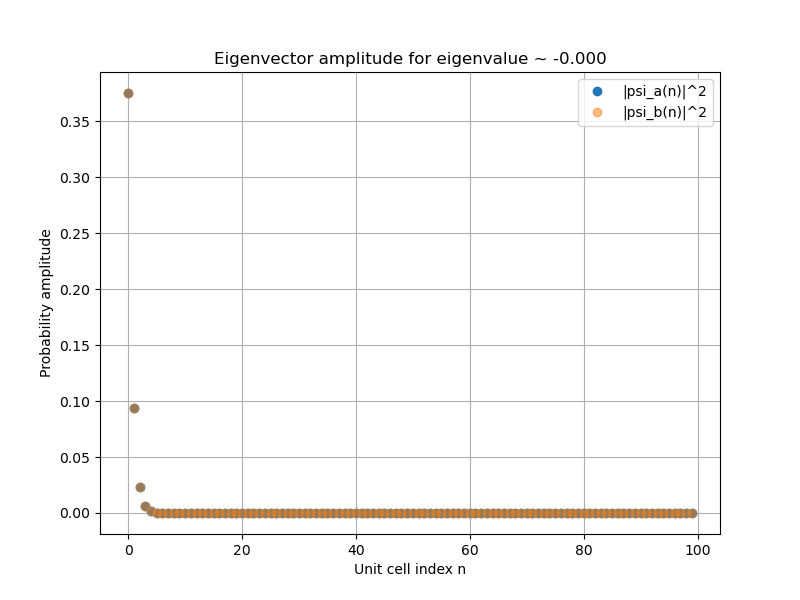

In [11]:

# 2) Pick an eigenstate index, for example the middle of the spectrum if there's a gap
mid_index = dim // 2 - 1 # or any other index of interest
# mid_index = 10 # or any other index of interest
eigenvalue_of_interest = eigvals_sorted[mid_index]
eigenvector_of_interest = eigvecs_sorted[:, mid_index]  # column

print(f"Chosen eigenvalue ~ {eigenvalue_of_interest}")

# 3) Separate amplitude for each site, recall basis: 2n -> a_n, 2n+1 -> b_n
amplitudes_a = []
amplitudes_b = []
for n in range(N):
    amp_a_n = eigenvector_of_interest[2*n]
    amp_b_n = eigenvector_of_interest[2*n+1]
    amplitudes_a.append(np.abs(amp_a_n)**2)
    amplitudes_b.append(np.abs(amp_b_n)**2)

# 4) Plot to see if it is localized near boundaries
sites = np.arange(N)  # site index
plt.figure(figsize=(8,6))
plt.plot(sites, amplitudes_a, 'o', label='|psi_a(n)|^2')
plt.plot(sites, amplitudes_b, 'o', label='|psi_b(n)|^2', alpha=0.5)
plt.xlabel('Unit cell index n')
plt.ylabel('Probability amplitude')
plt.title(f'Eigenvector amplitude for eigenvalue ~ {eigenvalue_of_interest:.3f}')
plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()


In [12]:
x, y, z = sq_ext.pauli_matrices()
np.kron(y,z) + np.kron(z,y)
# np.imag(np.kron(y,z)).astype('int') + np.imag(np.kron(y,z)).astype('int')

array([[ 0.+0.j,  0.-1.j,  0.-1.j,  0.-0.j],
       [ 0.+1.j,  0.+0.j,  0.+0.j,  0.+1.j],
       [ 0.+1.j,  0.+0.j,  0.+0.j,  0.+1.j],
       [ 0.+0.j,  0.-1.j,  0.-1.j, -0.+0.j]])

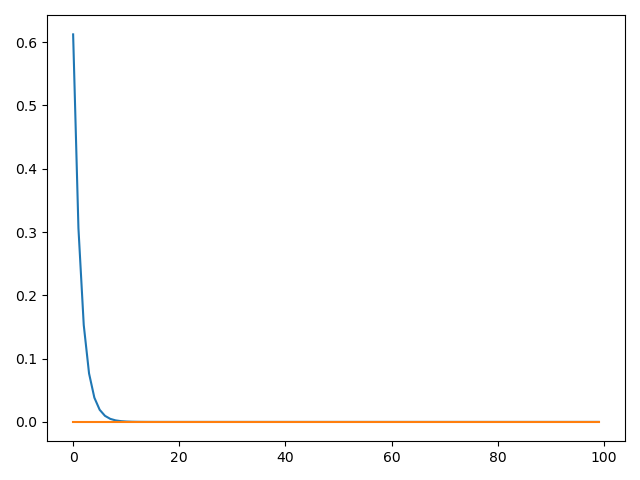

In [13]:
fig, ax = plt.subplots()

ax.plot(np.real(eigenvector_of_interest[::2]))
ax.plot(np.imag(eigenvector_of_interest[::2]))

fig.tight_layout()

In [14]:
E_real_vs_case = []
Amp_real_vs_case = []

for [δ, g_Φ, g_c, g_q] in cases:

    omega_c =  -δ/2 # Onsite frequency for mode a (resonator)
    omega_q =  δ/2 # Onsite frequency for mode b (qubit)
    N=100
    dim=2*N
    
    H_real = cm.real_H_unit_cell_boson_ladder(omega_c,omega_q, g_Φ,g_c,g_q, N=100)
    
    eigvals_real, eigvecs_real = np.linalg.eig(H_real)
    eigvals_real = np.real(eigvals_real)
    idx_sort = np.argsort(eigvals_real)
    eigvals_sorted = eigvals_real[idx_sort]
    eigvecs_sorted = eigvecs_real[:, idx_sort]  # columns are eigenvectors
    
    E_real_vs_case.append(eigvals_sorted)
    
    mid_index = dim // 2
    eigenvalue_of_interest = eigvals_sorted[mid_index]
    eigenvector_of_interest = eigvecs_sorted[:, mid_index]  # column
    
    amplitudes_a = []
    amplitudes_b = []
    for n in range(N):
        amp_a_n = eigenvector_of_interest[2*n]
        amp_b_n = eigenvector_of_interest[2*n+1]
        amplitudes_a.append(np.abs(amp_a_n)**2)
        amplitudes_b.append(np.abs(amp_b_n)**2)
    
    Amp_real_vs_case.append((amplitudes_a,amplitudes_b))


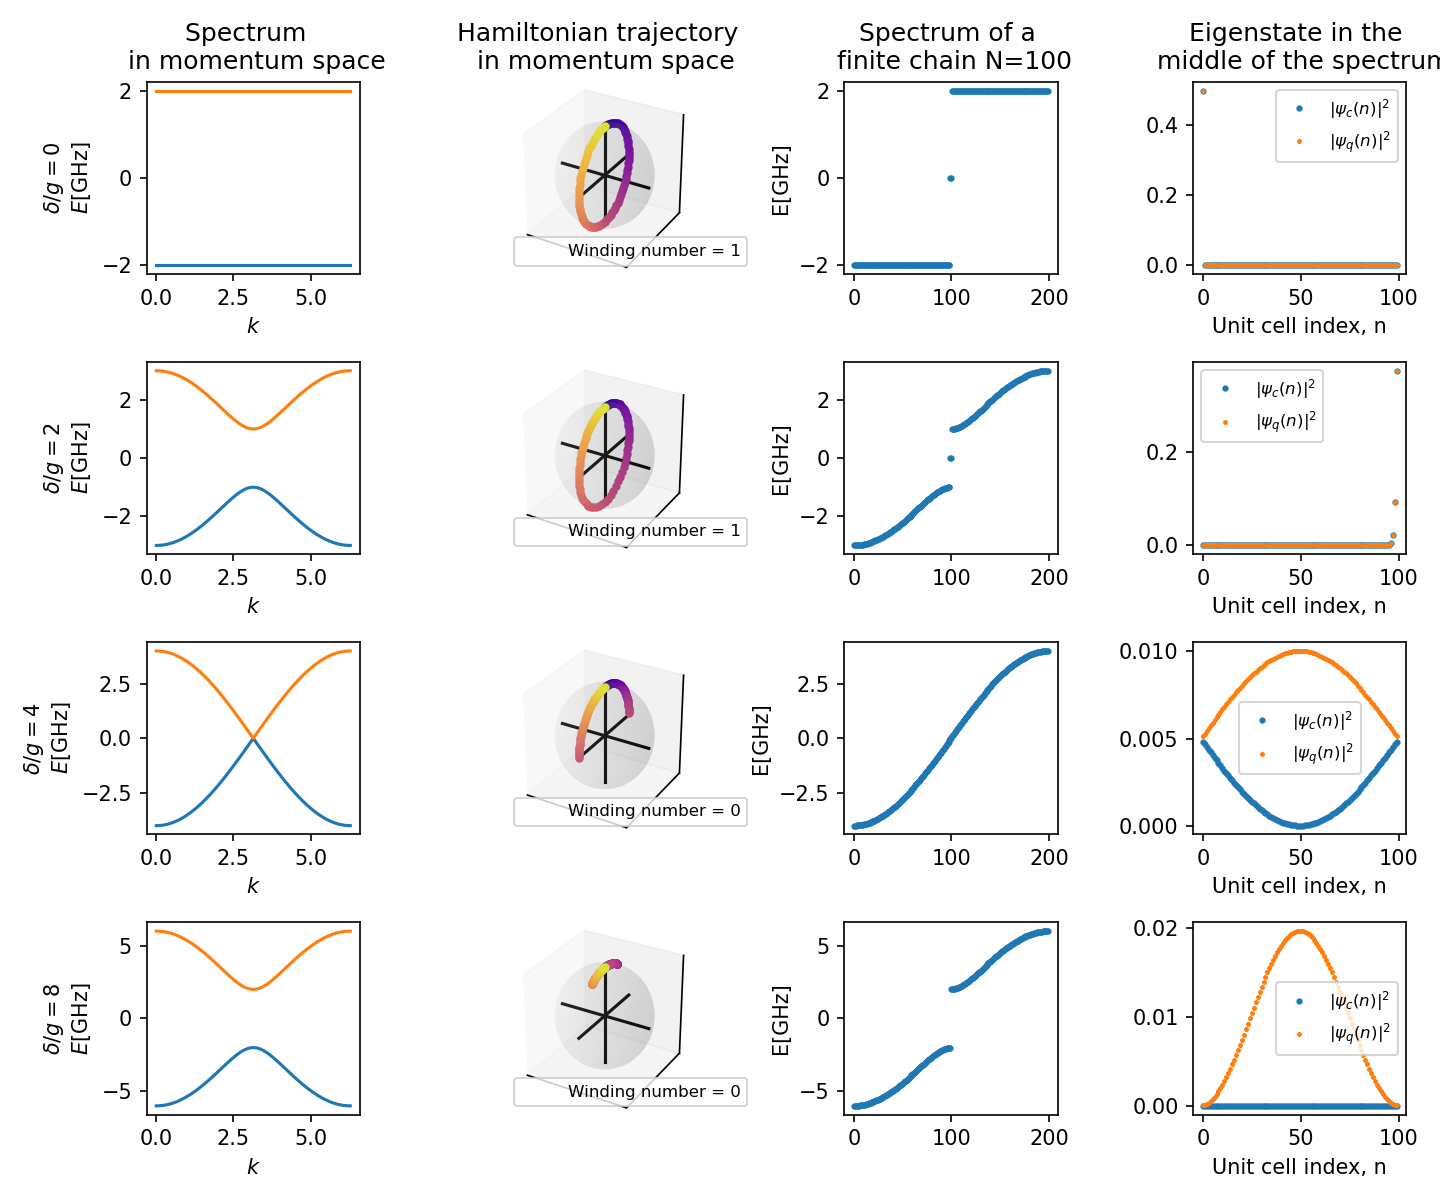

In [15]:
colors = figs.generate_colors_from_colormap(len(k_values), 'plasma')
fig = plt.figure(figsize=np.array([12, 10])*0.8, dpi=150)

nc = len(cases)
for i, case in enumerate(cases): 
    
    base = i * 4
    ax1 = fig.add_subplot(nc , 4, base+1)
    ax2 = fig.add_subplot(nc,4, base+2, projection='3d')
    ax3 = fig.add_subplot(nc , 4, base+3)
    ax4 = fig.add_subplot(nc , 4, base+4)   
    
    if i ==0:
        ax1.set_title("Spectrum  \n in momentum space")
        ax2.set_title('Hamiltonian trajectory \n in momentum space')
        ax3.set_title(f'Spectrum of a \n finite chain N={N}')
        ax4.set_title('Eigenstate in the \n middle of the spectrum')
    
    winding_int = (winding_number[i]).astype('int')
    ax2.plot([],[],'o', color='white', label=rf'Winding number = {winding_int}', markersize=0)
    ax2.legend(loc=3, fontsize=8)

    ax = [ax1, ax2, ax3, ax4]
    
    #Energy bands
    ax[0].plot(k_values, E_k[i, :, 0])
    ax[0].plot(k_values, E_k[i, :, 1])
    ax[0].set_ylabel(cases_titles[i]+'\n'+r'$E$[GHz]')
    ax[0].set_xlabel('$k$')

    ax[1].plot_surface(x_sphere, y_sphere, z_sphere, color='lightgray', alpha=0.1)
    ax[1].plot([-1,1], [0,0], [0,0],'k')
    ax[1].plot([0,0],[-1,1],  [0,0],'k')
    ax[1].plot( [0,0], [0,0],[-1,1],'k')
    
    hx, hy, hz  = [ np.zeros(len(k_values)) for _ in range(3)]
    for j in range(len(k_values)):
        _, hx[j], hy[j], hz[j] =  sq_ext.decomposition_in_pauli_2x2(H_k[i,j])
        
    norm = np.sqrt(hx**2 + hy**2 + hz**2)
    hx /= norm
    hy /= norm
    hz /= norm
    
    for j in range(len(k_values)):
        ax[1].plot(hx[j], hy[j], hz[j],'.', color=colors[j])

    # ax[1].set_xlabel(r'$\sigma_x$')
    # ax[1].set_ylabel(r'$\sigma_y$')
    # ax[1].set_zlabel(r'$\sigma_z$')
    ax[1].set_box_aspect([1,1,1])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_zticks([])
    
    ax[2].plot (E_real_vs_case[i], 'o', label='Eigenvalues', markersize=2)
    ax[2].set_ylabel('E[GHz]')
    
    ax[3] .plot(Amp_real_vs_case[i][0], 'o', label=r'$|\psi_c(n)|^2$', markersize=2)
    ax[3] .plot(Amp_real_vs_case[i][1], '*', label=r'$|\psi_q(n)|^2$', markersize=2)
    ax[3].legend(fontsize=8)
    ax[3].set_xlabel('Unit cell index, n')
    
fig.tight_layout()

figs.export('topological_clasification_ladder.pdf', fig)

In [16]:
plt.close('all')

# Perturbations around ideal topological phase

### $g_\Phi \ne 0 $

In [17]:
k_values = np.linspace(-np.pi, np.pi, 101)
# g_Φ_values = np.concatenate( (np.linspace(1e-2, 1e1, 20), np.linspace(1e1, 1e2, 5)),0)
g_Φ_values = np.linspace(1e-2, 1e1, 20)
N = 100
dim = 2 * N

E_k_vs_case_g_Φ        = np.zeros([len(cases), len(g_Φ_values), len(k_values),2])
E_real_vs_case_g_Φ     = np.zeros([len(cases), len(g_Φ_values), dim])
Amp_a_real_vs_case_g_Φ = np.zeros([len(cases), len(g_Φ_values), N])
Amp_b_real_vs_case_g_Φ = np.zeros([len(cases), len(g_Φ_values), N])
gap_border_states_vs_case_g_Φ = np.zeros([len(cases), len(g_Φ_values) ])


for m, case in enumerate(cases):
    print(m)
    δ, _, g_c, g_q = case
    
    for i, g_Φ in enumerate(g_Φ_values):
        
        for j, k in enumerate(k_values):
            H_k  = cm.momentum_H_unit_cell_boson_ladder(δ, g_Φ, g_c, g_q, k)
            E_k_vs_case_g_Φ[m,i,j] = np.linalg.eigh(H_k)[0]
        
        H_real = cm.real_H_unit_cell_boson_ladder(-δ / 2, δ / 2, g_Φ, g_c, g_q, N)
    
        eigvals_real, eigvecs_real = np.linalg.eig(H_real)
        eigvals_real = np.real(eigvals_real)
        idx_sort = np.argsort(eigvals_real)
        eigvals_sorted = eigvals_real[idx_sort]
        eigvecs_sorted = eigvecs_real[:, idx_sort]  # columns are eigenvectors
    
        E_real_vs_case_g_Φ[m,i] = eigvals_sorted
    
        mid_index = dim // 2
        eigenvalue_of_interest = eigvals_sorted[mid_index]
        eigenvector_of_interest = eigvecs_sorted[:, mid_index]  # column
        amplitudes_a = []
        amplitudes_b = []
        for n in range(N):
            amp_a_n = eigenvector_of_interest[2 * n]
            amp_b_n = eigenvector_of_interest[2 * n + 1]
            amplitudes_a.append(np.abs(amp_a_n) ** 2)
            amplitudes_b.append(np.abs(amp_b_n) ** 2)
    
        Amp_a_real_vs_case_g_Φ[m, i] = amplitudes_a
        Amp_b_real_vs_case_g_Φ[m, i] = amplitudes_b
        
    gap_border_states_vs_case_g_Φ[m] = E_real_vs_case_g_Φ[m,:,mid_index+1]- E_real_vs_case_g_Φ[m,:,mid_index]
    

0
1
2
3


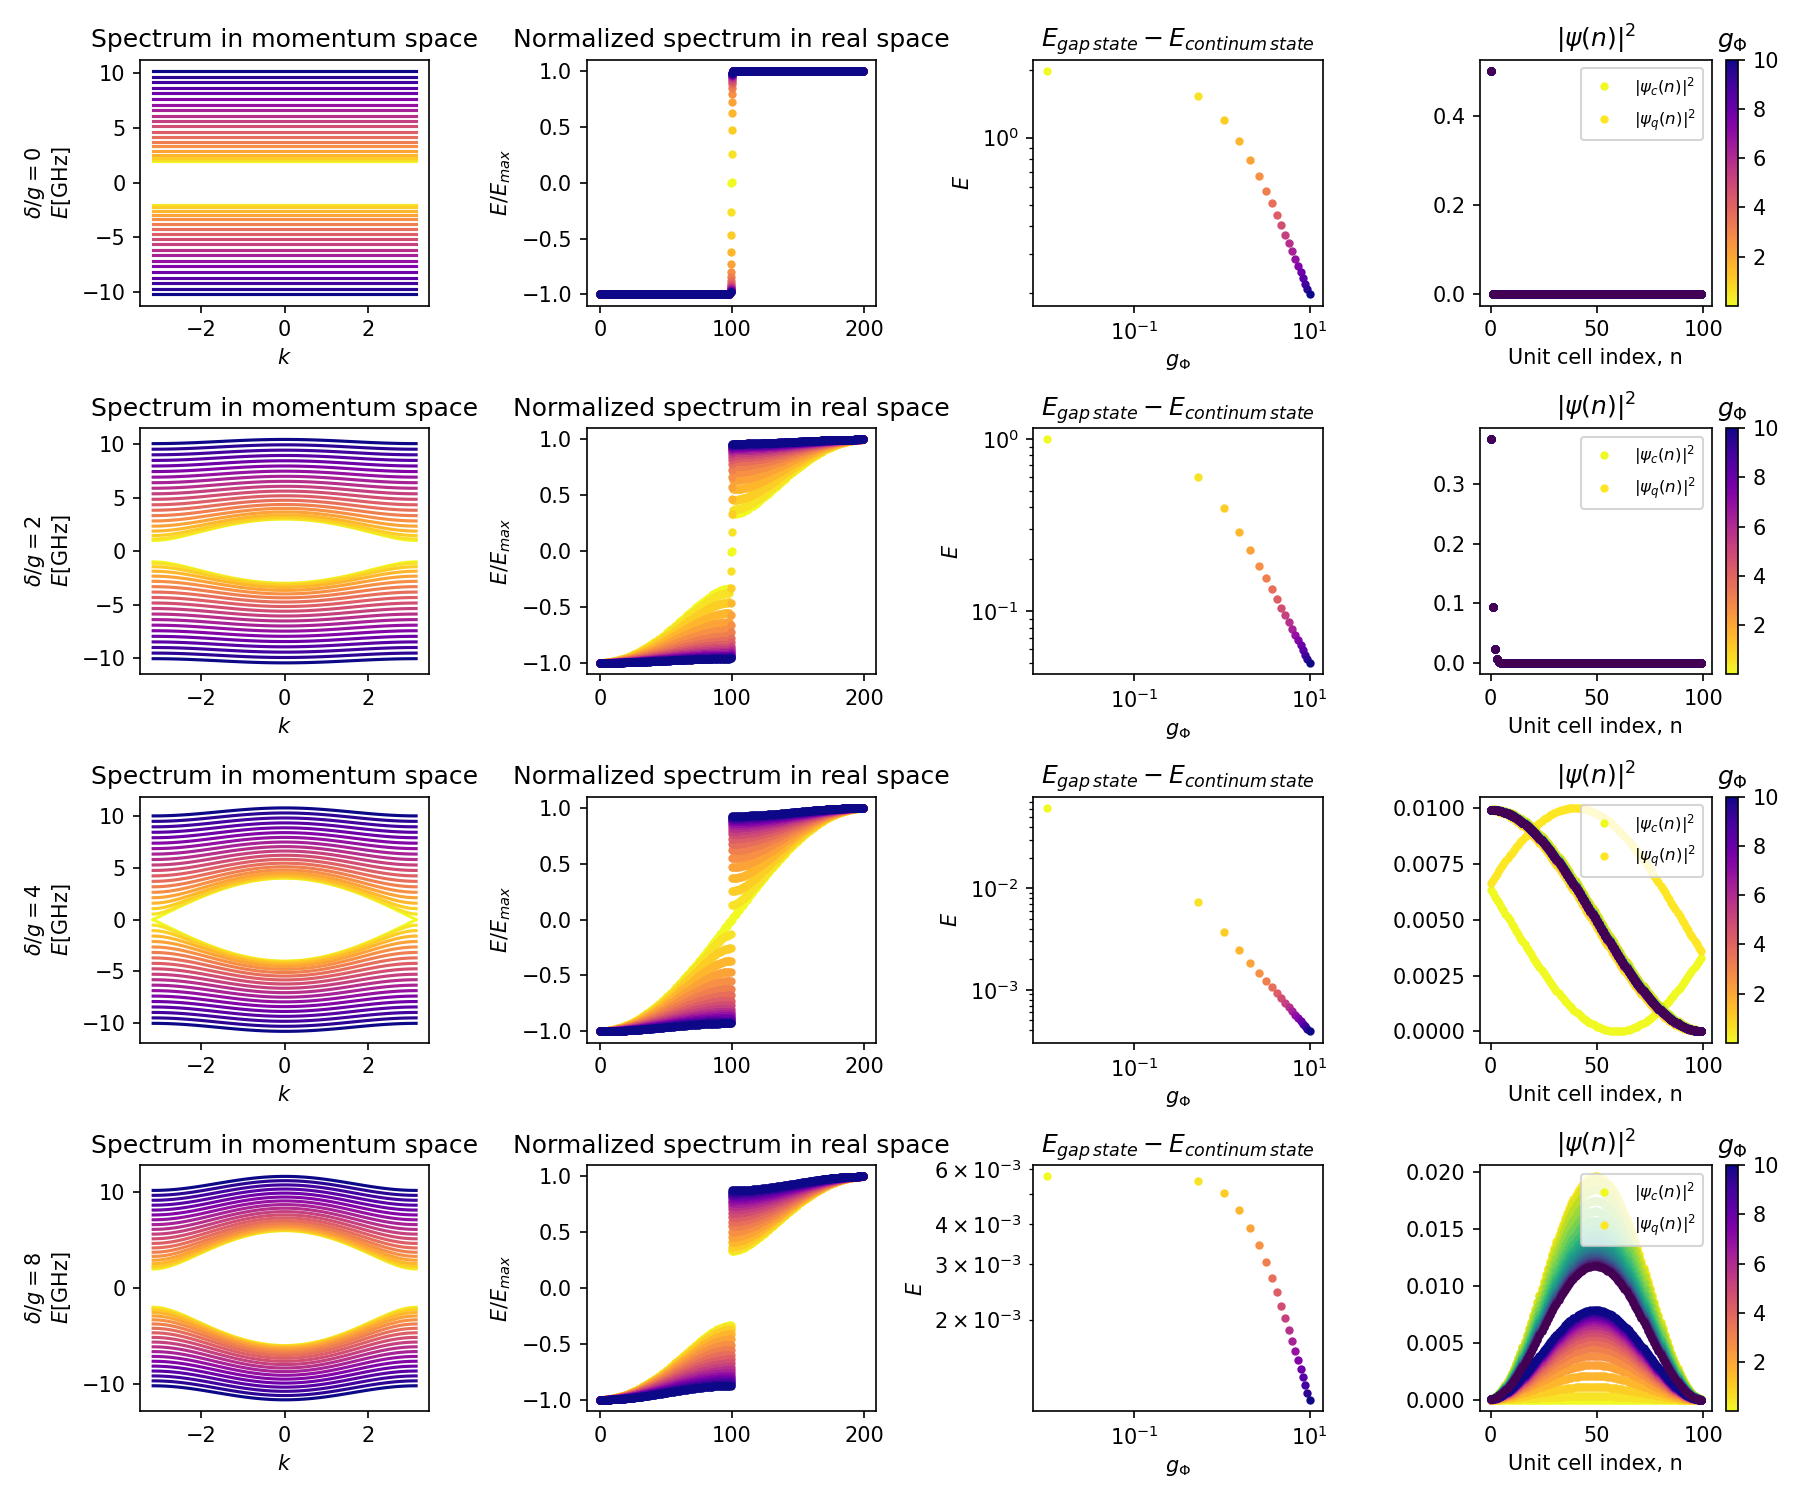

In [18]:
colors = figs.generate_colors_from_colormap(len(g_Φ_values),'plasma_r')
colors2 = figs.generate_colors_from_colormap(len(g_Φ_values),'viridis_r')

fig = plt.figure(figsize=(12, 10), dpi=150)

nc = len(cases)
for m, case in enumerate(cases): 
    
    base = m * 4
    
    ax1 = fig.add_subplot(nc , 4, base+1)
    ax1.set_title("Spectrum in momentum space")
    ax2 = fig.add_subplot(nc,4, base+2 )
    ax2.set_title('Normalized spectrum in real space')
    ax3 = fig.add_subplot(nc , 4, base+3)
    ax3.set_title(r'$E_{gap\,state} - E_{continum\,state}$')
    ax4 = fig.add_subplot(nc , 4, base+4)
    ax4.set_title(r'$|\psi(n)|^2$')

    ax = [ax1, ax2, ax3, ax4]
    

    for i in range(len(g_Φ_values)):
        
        # Spectrum im momentum space
        ax[0].plot(k_values, E_k_vs_case_g_Φ[m, i, :, 0], color=colors[i])
        ax[0].plot(k_values, E_k_vs_case_g_Φ[m, i, :, 1], color=colors[i])
        
        ax[1].plot(E_real_vs_case_g_Φ[m,i]/np.max(E_real_vs_case_g_Φ[m,i]),'.', color=colors[i])
        # ax[1].plot(E_real_vs_case_g_Φ[m,i] ,'.', color=colors[i])
        
    
        # ax[2].plot(g_Φ_values[i], gap_border_states_vs_case_g_Φ[m,i]/np.max(E_real_vs_case_g_Φ[m,i]), '.', color=colors[i])
        ax[2].plot(g_Φ_values[i], gap_border_states_vs_case_g_Φ[m,i], '.', color=colors[i])
    
        ax[3].plot(Amp_a_real_vs_case_g_Φ[m,i], '.', color=colors[i], label=r'$|\psi_c(n)|^2$')
        ax[3].plot(Amp_b_real_vs_case_g_Φ[m,i], '.', color=colors2[i], label=r'$|\psi_q(n)|^2$')
        if i==0:
            ax[3].legend(fontsize=8)
            
    ax[0].set_ylabel(cases_titles[m]+'\n'+r'$E$[GHz]')
    ax[0].set_xlabel('$k$')
        
    ax[3].set_xlabel('Unit cell index, n')
    ax[1].set_ylabel(r'$E/E_{max}$')

    ax[2].set_xlabel(f'$g_\Phi$')
    ax[2].set_ylabel(r'$E$')
    ax[2].set_yscale('log')
    ax[2].set_xscale('log')
    figs.colorbar_for_lines(fig, ax[3], g_Φ_values,'plasma_r',r'$g_\Phi$')    

    
fig.tight_layout()

# figs.export('topological_clasification_ladder.pdf', fig)
#

In [19]:
plt.close('all')

In [20]:
δ, g_Φ, g_c, g_q  = cases[0]

g_Φ_values = np.linspace(1e-2, 1e1, 20) 

In [21]:
N=100
dim=2*N

E_real_vs_g_Φ     = np.zeros([len(g_Φ_values), dim])
Amp_a_real_vs_g_Φ = np.zeros([len(g_Φ_values), N])
Amp_b_real_vs_g_Φ = np.zeros([len(g_Φ_values), N])

for i, g_Φ in enumerate(g_Φ_values):
    H_real = cm.real_H_unit_cell_boson_ladder(-δ/2, δ/2, g_Φ,g_c,g_q, N )
    
    eigvals_real, eigvecs_real = np.linalg.eig(H_real)
    eigvals_real = np.real(eigvals_real)
    idx_sort = np.argsort(eigvals_real)
    eigvals_sorted = eigvals_real[idx_sort]
    eigvecs_sorted = eigvecs_real[:, idx_sort]  # columns are eigenvectors
    
    E_real_vs_g_Φ[i] = eigvals_sorted 
    
    mid_index = dim // 2
    eigenvalue_of_interest = eigvals_sorted[mid_index]
    eigenvector_of_interest = eigvecs_sorted[:, mid_index]  # column
    amplitudes_a = []
    amplitudes_b = []
    for n in range(N):
        amp_a_n = eigenvector_of_interest[2*n]
        amp_b_n = eigenvector_of_interest[2*n+1]
        amplitudes_a.append(np.abs(amp_a_n)**2)
        amplitudes_b.append(np.abs(amp_b_n)**2)
    
    Amp_a_real_vs_g_Φ[i] = amplitudes_a 
    Amp_b_real_vs_g_Φ[i] = amplitudes_b 


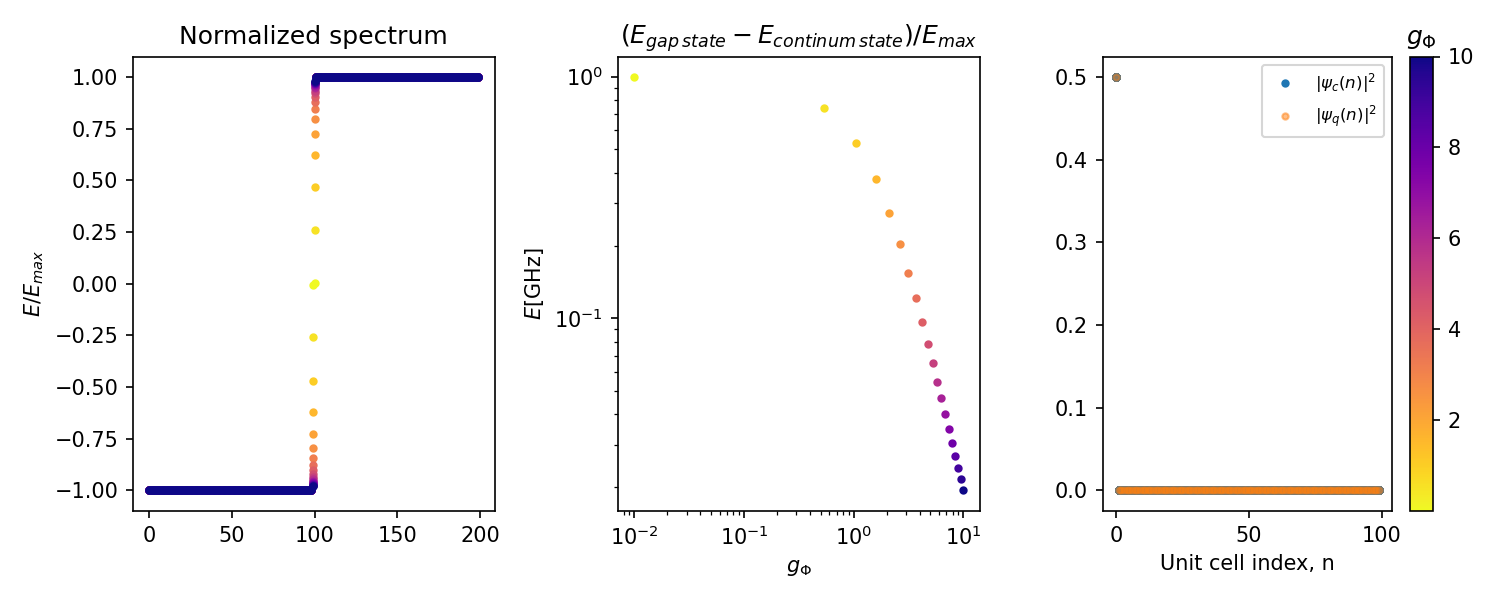

In [22]:
gap_border_states = E_real_vs_g_Φ[:,mid_index+1]- E_real_vs_g_Φ[:,mid_index]

colors = figs.generate_colors_from_colormap(len(g_Φ_values),'plasma_r')

fig, (ax0, ax, ax1 )= plt.subplots(ncols=3, figsize=[10,4] ,dpi=150)

for i in range(len(g_Φ_values)):
    ax0.plot(E_real_vs_g_Φ[i]/np.max(E_real_vs_g_Φ[i]),'.', color=colors[i])
    # ax0.plot(E_real_vs_g_Φ[i] ,'.', color=colors[i])
    

    ax.plot(g_Φ_values[i], gap_border_states[i]/np.max(E_real_vs_g_Φ[i]), '.', color=colors[i])
    # ax.plot(g_Φ_values[i], gap_border_states[i], '.', color=colors[i])

    ax1.plot(Amp_a_real_vs_g_Φ[i], '.',color='tab:blue', label=r'$|\psi_c(n)|^2$')
    ax1.plot(Amp_b_real_vs_g_Φ[i], '.',color='tab:orange', label=r'$|\psi_q(n)|^2$', alpha=0.5)
    if i==0:
        ax1.legend(fontsize=8)
    ax1.set_xlabel('Unit cell index, n')

ax0.set_title('Normalized spectrum')
ax0.set_ylabel(r'$E/E_{max}$')

ax.set_xlabel(f'$g_\Phi$')
ax.set_ylabel(f'$E$[GHz]')
ax.set_title(r'$(E_{gap\,state} - E_{continum\,state})/E_{max}$')
ax.set_yscale('log')
ax.set_xscale('log')
figs.colorbar_for_lines(fig, ax1, g_Φ_values,'plasma_r',r'$g_\Phi$')    

fig.tight_layout()

In [23]:
plt.close('all')

## Perturbations around ideal topological phase

### $g_c \ne g_q $

In [24]:
k_values = np.linspace(-np.pi, np.pi, 101)
δ_g_c_values = np.linspace(0, 1e0, 10) * 2

N = 100
dim = 2 * N

E_k_vs_case_δ_g_c        = np.zeros([len(cases), len(δ_g_c_values), len(k_values),2])
E_real_vs_case_δ_g_c     = np.zeros([len(cases), len(δ_g_c_values), dim])
Amp_a_real_vs_case_δ_g_c = np.zeros([len(cases), len(δ_g_c_values), N])
Amp_b_real_vs_case_δ_g_c = np.zeros([len(cases), len(δ_g_c_values), N])
gap_border_states_vs_case_δ_g_c = np.zeros([len(cases), len(δ_g_c_values) ])


for m, case in enumerate(cases):
    print(m)
    δ, g_Φ, g_c, g_q = case
    
    for i, δ_g_c in enumerate(δ_g_c_values):
        
        for j, k in enumerate(k_values):
            H_k  = cm.momentum_H_unit_cell_boson_ladder(δ, g_Φ, g_c+δ_g_c, g_q, k)
            E_k_vs_case_δ_g_c[m,i,j] = np.linalg.eigh(H_k)[0]
        
        H_real = cm.real_H_unit_cell_boson_ladder(-δ / 2, δ / 2, g_Φ, g_c+δ_g_c, g_q, N)
    
        eigvals_real, eigvecs_real = np.linalg.eig(H_real)
        eigvals_real = np.real(eigvals_real)
        idx_sort = np.argsort(eigvals_real)
        eigvals_sorted = eigvals_real[idx_sort]
        eigvecs_sorted = eigvecs_real[:, idx_sort]  # columns are eigenvectors
    
        E_real_vs_case_δ_g_c[m,i] = eigvals_sorted
    
        mid_index = dim // 2
        eigenvalue_of_interest = eigvals_sorted[mid_index]
        eigenvector_of_interest = eigvecs_sorted[:, mid_index]  # column
        amplitudes_a = []
        amplitudes_b = []
        for n in range(N):
            amp_a_n = eigenvector_of_interest[2 * n]
            amp_b_n = eigenvector_of_interest[2 * n + 1]
            amplitudes_a.append(np.abs(amp_a_n) ** 2)
            amplitudes_b.append(np.abs(amp_b_n) ** 2)
    
        Amp_a_real_vs_case_δ_g_c[m, i] = amplitudes_a
        Amp_b_real_vs_case_δ_g_c[m, i] = amplitudes_b
        
    gap_border_states_vs_case_δ_g_c[m] = E_real_vs_case_δ_g_c[m,:,mid_index+1]- E_real_vs_case_δ_g_c[m,:,mid_index]
    

0
1
2
3


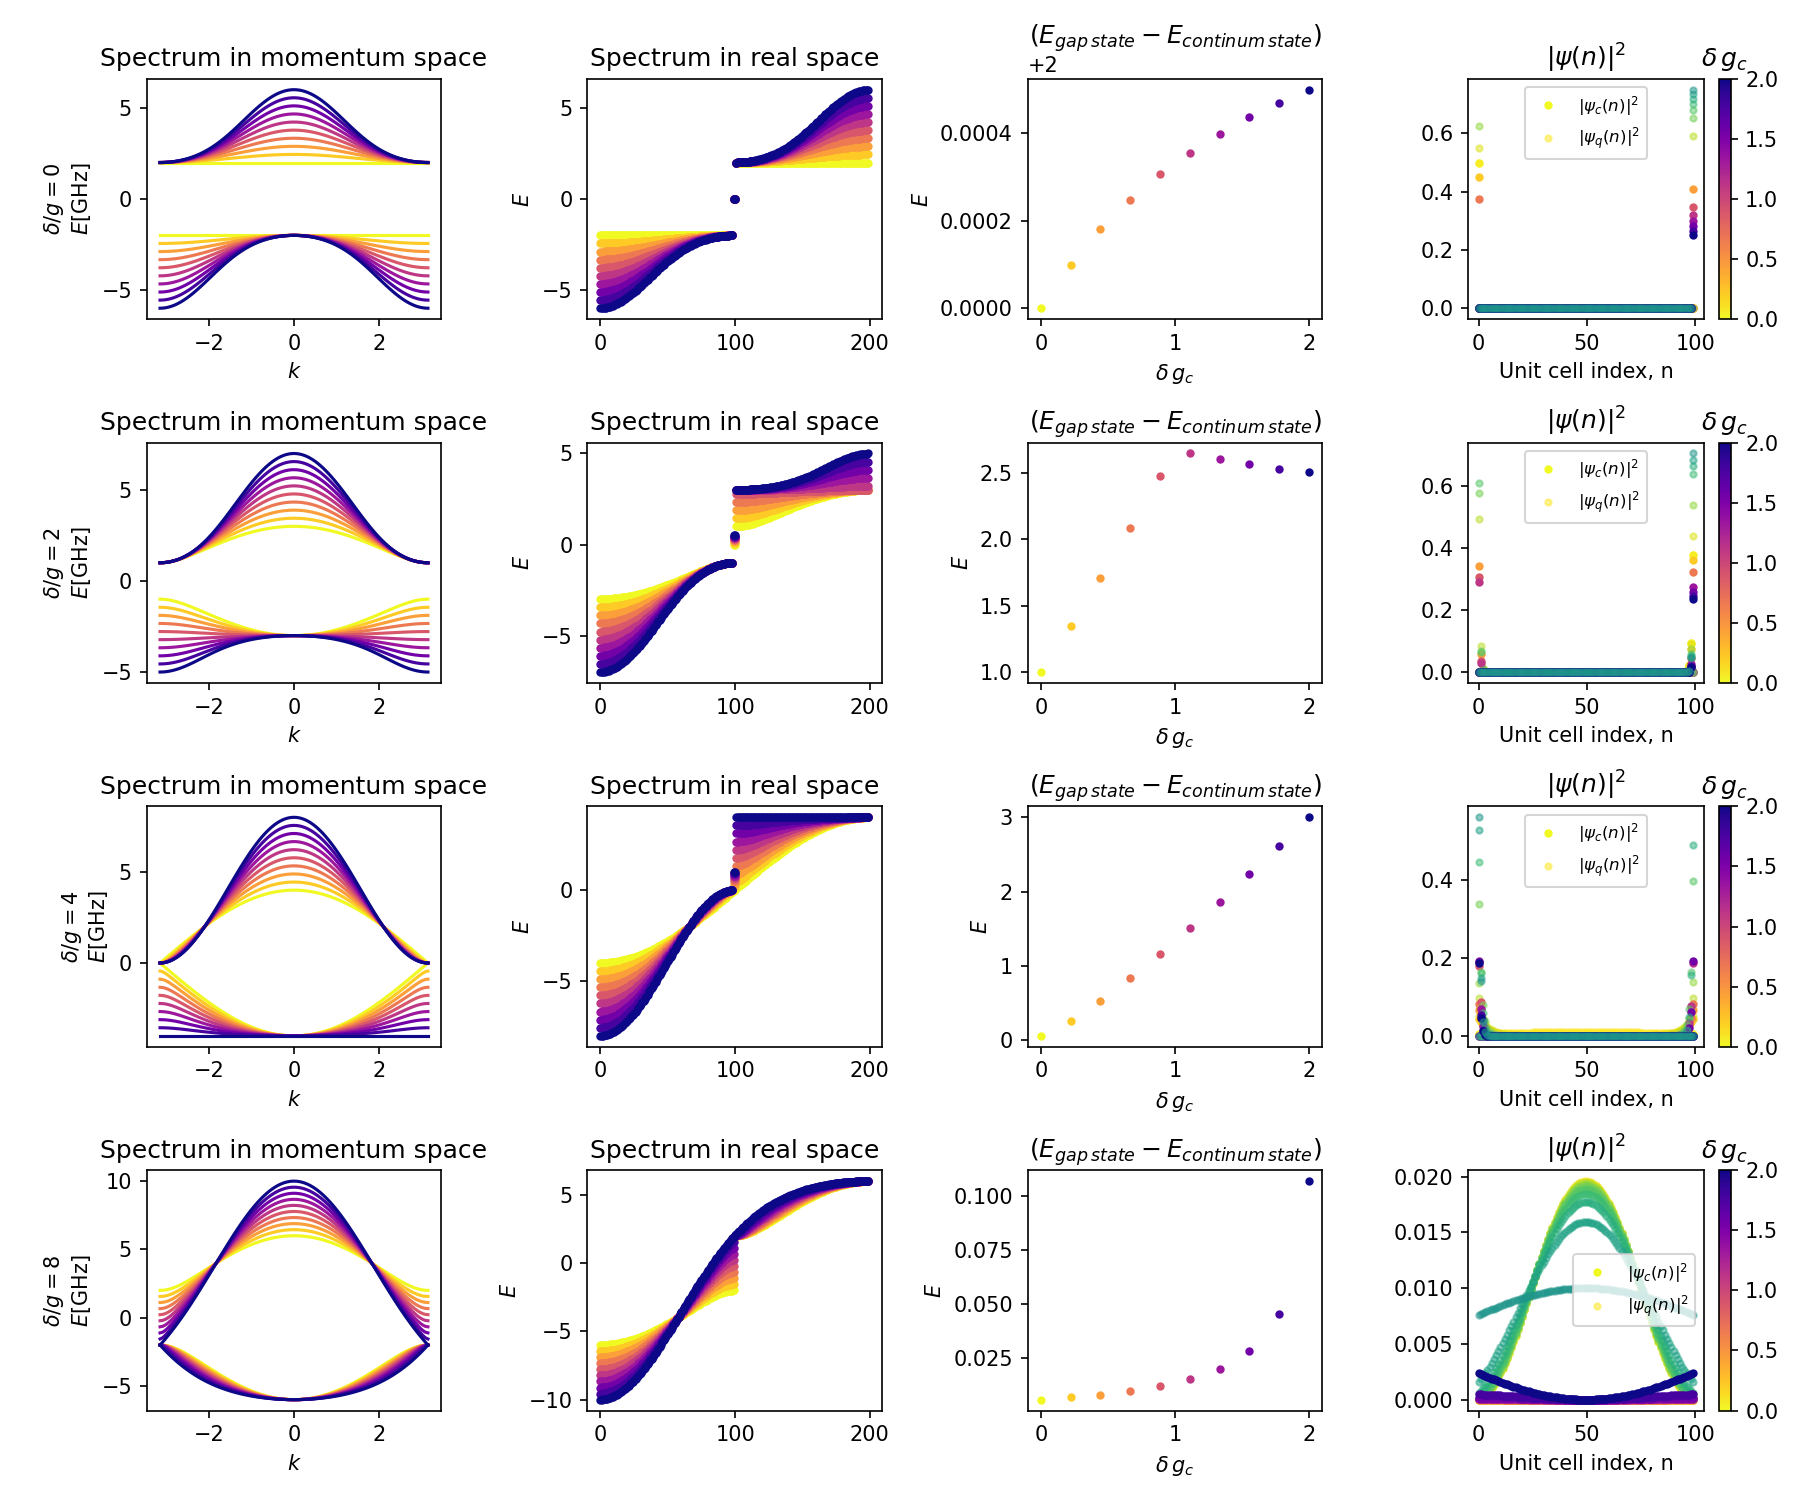

In [25]:
colors = figs.generate_colors_from_colormap(len(δ_g_c_values),'plasma_r')

fig = plt.figure(figsize=(12, 10), dpi=150)

nc = len(cases)
for m, case in enumerate(cases): 
    
    base = m * 4
    
    ax1 = fig.add_subplot(nc , 4, base+1)
    ax1.set_title("Spectrum in momentum space")
    ax2 = fig.add_subplot(nc,4, base+2 )
    ax2.set_title('Spectrum in real space')
    ax3 = fig.add_subplot(nc , 4, base+3)
    ax3.set_title(r'$(E_{gap\,state} - E_{continum\,state})$')
    ax4 = fig.add_subplot(nc , 4, base+4)
    ax4.set_title(r'$|\psi(n)|^2$')

    ax = [ax1, ax2, ax3, ax4]
    

    for i in range(len(δ_g_c_values)):
        
        # Spectrum im momentum space
        ax[0].plot(k_values, E_k_vs_case_δ_g_c[m, i, :, 0], color=colors[i])
        ax[0].plot(k_values, E_k_vs_case_δ_g_c[m, i, :, 1], color=colors[i])
        
        # ax[1].plot(E_real_vs_case_δ_g_c[m,i]/np.max(E_real_vs_case_δ_g_c[m,i]),'.', color=colors[i])
        ax[1].plot(E_real_vs_case_δ_g_c[m,i] ,'.', color=colors[i])
        
    
        # ax[2].plot(δ_g_c_values[i], gap_border_states_vs_case_δ_g_c[m,i]/np.max(E_real_vs_case_δ_g_c[m,i]), '.', color=colors[i])
        ax[2].plot(δ_g_c_values[i], gap_border_states_vs_case_δ_g_c[m,i], '.', color=colors[i])
    
        ax[3].plot(Amp_a_real_vs_case_δ_g_c[m,i], '.', color=colors[i], label=r'$|\psi_c(n)|^2$')
        ax[3].plot(Amp_b_real_vs_case_δ_g_c[m,i], '.', color=colors2[i], label=r'$|\psi_q(n)|^2$', alpha=0.5)
        if i==0:
            ax[3].legend(fontsize=8)
            
    ax[0].set_ylabel(cases_titles[m]+'\n'+r'$E$[GHz]')
    ax[0].set_xlabel('$k$')
        
    ax[3].set_xlabel('Unit cell index, n')
    ax[1].set_ylabel(r'$E$')

    ax[2].set_xlabel(f'$\delta\, g_c$ ')
    ax[2].set_ylabel(r'$E$')
    # ax[2].set_yscale('log')
    # ax[2].set_xscale('log')
    figs.colorbar_for_lines(fig, ax[3], δ_g_c_values,'plasma_r',r'$\delta\, g_c$')    

    
fig.tight_layout()

# figs.export('topological_clasification_ladder.pdf', fig)
#

In [26]:
δ, g_Φ, g_c, g_q  = cases[1]

# δ_g_c_values = np.linspace(0, 1e0, 10) 
δ_g_c_values = np.linspace(0, 1e0, 10) * δ

In [27]:
N=100
dim=2*N

E_real_vs_δ_g_c     = np.zeros([len(δ_g_c_values), dim])
Amp_a_real_vs_δ_g_c = np.zeros([len(δ_g_c_values), N])
Amp_b_real_vs_δ_g_c = np.zeros([len(δ_g_c_values), N])

for i, δ_g_c in enumerate(δ_g_c_values):
    print(i)

    H_real = cm.real_H_unit_cell_boson_ladder(-δ/2, +δ/2, g_Φ, g_c+δ_g_c, g_q, N )
    
    eigvals_real, eigvecs_real = np.linalg.eig(H_real)
    eigvals_real = np.real(eigvals_real)
    idx_sort = np.argsort(eigvals_real)
    eigvals_sorted = eigvals_real[idx_sort]
    eigvecs_sorted = eigvecs_real[:, idx_sort]  # columns are eigenvectors
    
    E_real_vs_δ_g_c[i] = eigvals_sorted 
    
    mid_index = dim // 2
    eigenvalue_of_interest = eigvals_sorted[mid_index]
    eigenvector_of_interest = eigvecs_sorted[:, mid_index]  # column
    amplitudes_a = []
    amplitudes_b = []
    for n in range(N):
        amp_a_n = eigenvector_of_interest[2*n]
        amp_b_n = eigenvector_of_interest[2*n+1]
        amplitudes_a.append(np.abs(amp_a_n)**2)
        amplitudes_b.append(np.abs(amp_b_n)**2)
    
    Amp_a_real_vs_δ_g_c[i] = amplitudes_a 
    Amp_b_real_vs_δ_g_c[i] = amplitudes_b 


0
1
2
3
4
5
6
7
8
9


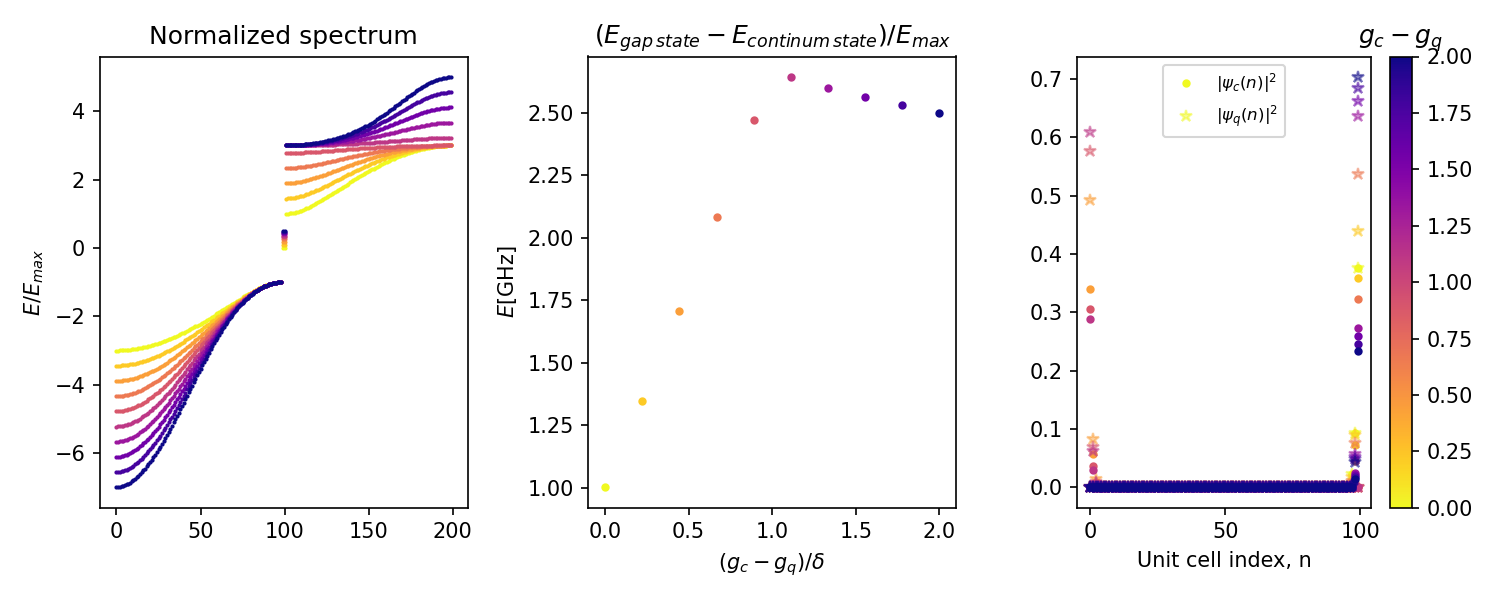

In [28]:
gap_border_states = E_real_vs_δ_g_c[:,mid_index+1]- E_real_vs_δ_g_c[:,mid_index]

colors = figs.generate_colors_from_colormap(len(δ_g_c_values),'plasma_r')

fig, (ax0, ax, ax1 )= plt.subplots(ncols=3, figsize=[10,4] ,dpi=150)

for i in range(len(δ_g_c_values)):
    # ax0.plot(E_real_vs_δ_g_c[i]/np.max(E_real_vs_δ_g_c[i]),'.', color=colors[i])
    ax0.plot(E_real_vs_δ_g_c[i] ,'.', color=colors[i],markersize=2)
    

    # ax.plot(δ_g_c_values[i], gap_border_states[i]/np.max(E_real_vs_δ_g_c[i]), '.', color=colors[i])
    ax.plot(δ_g_c_values[i], gap_border_states[i], '.', color=colors[i])

    ax1.plot(Amp_a_real_vs_δ_g_c[i], '.', color=colors[i], label=r'$|\psi_c(n)|^2$')
    ax1.plot(Amp_b_real_vs_δ_g_c[i], '*', color=colors[i], label=r'$|\psi_q(n)|^2$', alpha=0.5)
    if i==0:
        ax1.legend(fontsize=8)
    ax1.set_xlabel('Unit cell index, n')

ax0.set_title('Normalized spectrum')
ax0.set_ylabel(r'$E/E_{max}$')

ax.set_xlabel(f'$(g_c-g_q )/ \delta $')
ax.set_ylabel(f'$E$[GHz]')
ax.set_title(r'$(E_{gap\,state} - E_{continum\,state})/E_{max}$')

figs.colorbar_for_lines(fig, ax1, δ_g_c_values,'plasma_r',r'$g_c-g_q$')    

fig.tight_layout()

## Analytical solution for $g_\Phi =0 $ and $g_q=g_c$

In [29]:
δ, g_Φ, g_c, g_q = cases[1]
# δ=3

In [30]:

# g_c *=2
# g_q *=2
ω_0=0
ω_c = ω_0 - δ/2 # Onsite frequency for mode a (resonator)
ω_q = ω_0 + δ/2 # Onsite frequency for mode b (qubit)

N_values = np.linspace(11,31,20,dtype='int')
ΔE_vs_N = np.zeros(len(N_values))
Ψ_left_vs_N = []
Ψ_right_vs_N = []

for i, N in enumerate(N_values):
    H_real = cm.real_H_unit_cell_boson_ladder(ω_c, ω_q, g_Φ, g_c, g_q, N)
    
    E, Ψ = np.linalg.eigh(H_real)
    sorted_indices = np.argsort(np.real(E))
    E = E[sorted_indices]
    Ψ = Ψ[:,sorted_indices]
    ΔE_vs_N[i] = E[N]-E[N-1]
    Ψ_left_vs_N .append(Ψ[:,N-1])
    Ψ_right_vs_N.append(Ψ[:,N])


In [31]:
λ = δ / (4*g_c)
ΔE_vs_N_analytic = 4 * g_c * (1-λ**2) * λ **(N_values)  / (1-λ**(2*N_values) )
λ

0.5

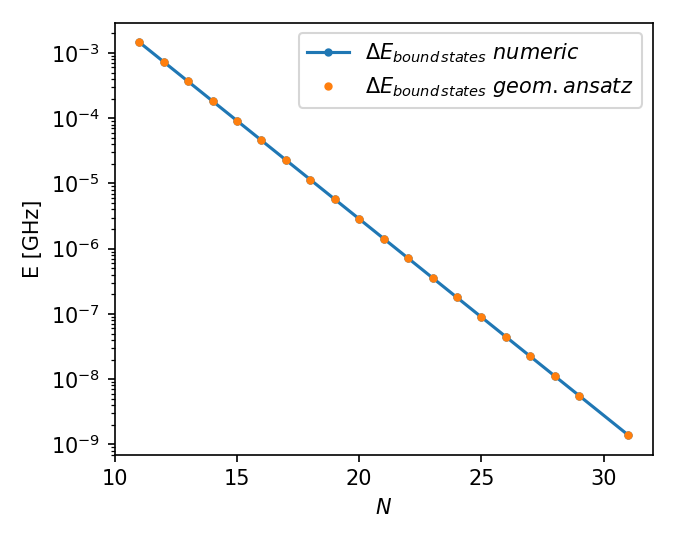

In [32]:
fig, ax = plt.subplots(figsize=np.array([5,4])*0.9, dpi=150)

ax.plot(N_values,  ΔE_vs_N , '.-', label=r'$\Delta E_{bound\, states} \,\,numeric$')
ax.plot(N_values,  ΔE_vs_N_analytic , '.', label=r'$\Delta E_{bound\, states} \,\,geom. ansatz$')  
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('$N$')
ax.set_ylabel('E [GHz]')
fig.tight_layout()
figs.export('Delta_E_analytical_sol.pdf', fig=fig)

In [33]:
ΔE_vs_N_analytic/ΔE_vs_N

array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [34]:
idx = -1
λ  = δ / (4 * g_c)
r = (λ) **2
N0 =  2 * np.sqrt( (1-r**N_values[idx]) / (1-r)  )
N0

2.309401076758503

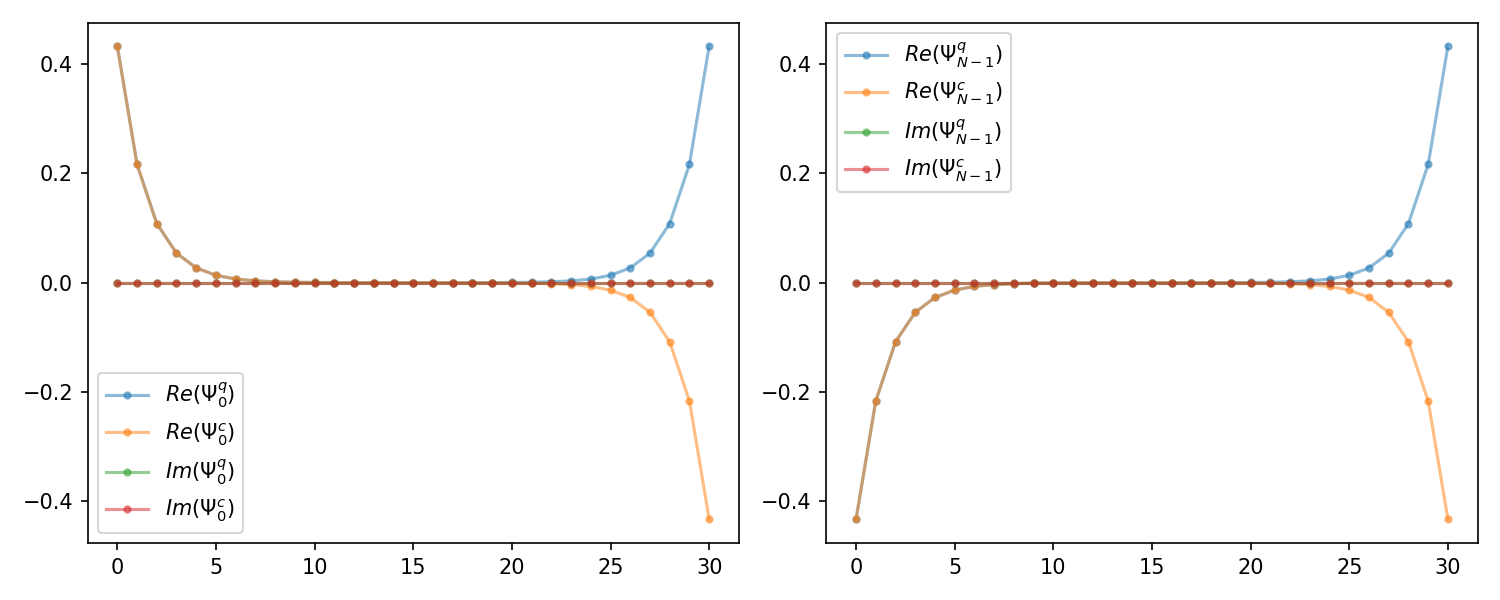

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[10,4], dpi=150)

ax1.plot(np.real(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_0^q)$', alpha=0.5)
ax1.plot(np.real(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_0^c)$', alpha=0.5)
ax1.plot(np.imag(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_0^q)$', alpha=0.5)
ax1.plot(np.imag(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_0^c)$', alpha=0.5)

ax2.plot(np.real(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_{N-1}^q)$', alpha=0.5)
ax2.plot(np.real(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_{N-1}^c)$', alpha=0.5)
ax2.plot(np.imag(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_{N-1}^q)$', alpha=0.5)
ax2.plot(np.imag(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_{N-1}^c)$', alpha=0.5)

ax1.legend()
ax2.legend()
fig.tight_layout()

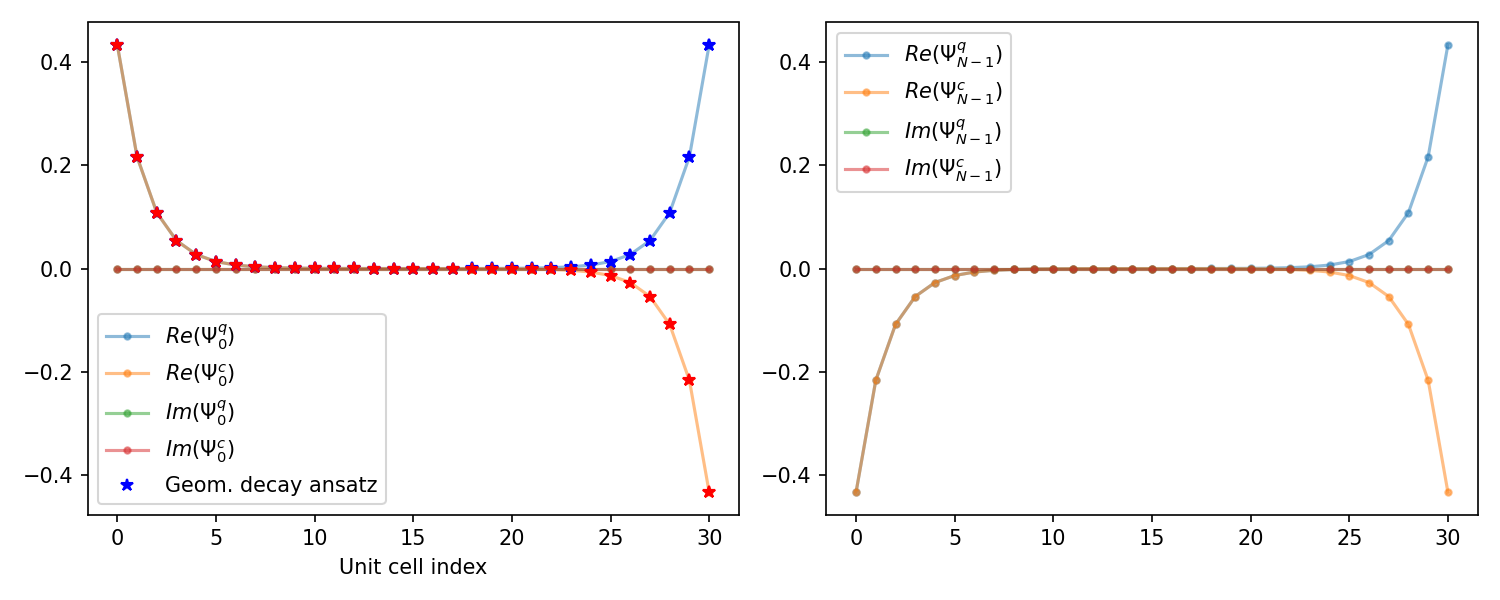

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[10,4], dpi=150)

ax1.plot(np.real(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_0^q)$', alpha=0.5)
ax1.plot(np.real(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_0^c)$', alpha=0.5)
ax1.plot(np.imag(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_0^q)$', alpha=0.5)
ax1.plot(np.imag(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_0^c)$', alpha=0.5)

ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) + 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*b')
ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) - 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*r')
# ax1.set_yscale('log')

ax2.plot(np.real(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_{N-1}^q)$', alpha=0.5)
ax2.plot(np.real(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_{N-1}^c)$', alpha=0.5)
ax2.plot(np.imag(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_{N-1}^q)$', alpha=0.5)
ax2.plot(np.imag(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_{N-1}^c)$', alpha=0.5)

ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) + 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*b', label='Geom. decay ansatz')
ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) - 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*r')

ax1.set_xlabel('Unit cell index')
ax1.legend()
ax2.legend()
fig.tight_layout()

figs.export('wavefunction_analytical_sol.pdf', fig=fig)

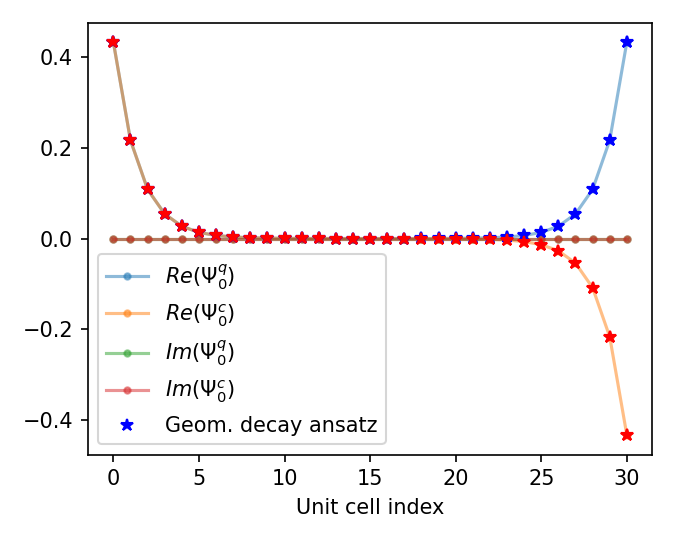

In [37]:
fig, ax1 = plt.subplots( figsize=np.array([5,4])*0.9, dpi=150)

ax1.plot(np.real(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_0^q)$', alpha=0.5)
ax1.plot(np.real(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_0^c)$', alpha=0.5)
ax1.plot(np.imag(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_0^q)$', alpha=0.5)
ax1.plot(np.imag(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_0^c)$', alpha=0.5)

ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) + 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*b')
ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) - 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*r')
# ax1.set_yscale('log')

ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) + 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*b', label='Geom. decay ansatz')
ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) - 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*r')

ax1.set_xlabel('Unit cell index')
ax1.legend()
fig.tight_layout()

figs.export('wavefunction_analytical_sol.pdf', fig=fig)

In [38]:
1/N0 * λ ** np.arange(N_values[idx]) / np.real(Ψ_left_vs_N[idx][0::2])

array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9998, 0.9990, 0.9961, 0.9846, 0.9412, 0.8000, 0.5000, 0.2000, 0.0588, 0.0154, 0.0039, 0.0010, 0.0002, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

## Analytical solution for $g_\Phi \ne0 $ and $g_q=g_c$

In [39]:
δ, g_Φ, g_c, g_q = cases[1]
g_Φ = 4
# g_c=0.05
# g_q=g_c
# δ=3
# δ=0
# δ=1
# δ=1

In [40]:
ω_0=0
ω_c = ω_0 - δ/2 # Onsite frequency for mode a (resonator)
ω_q = ω_0 + δ/2 # Onsite frequency for mode b (qubit)

N_values = np.linspace(11,30,20,dtype='int')
ΔE_vs_N = np.zeros(len(N_values))
ΔE_bulk_vs_N = np.zeros(len(N_values))
Ψ_left_vs_N = []
Ψ_right_vs_N = []

for i, N in enumerate(N_values):
    H_real = cm.real_H_unit_cell_boson_ladder(ω_c, ω_q, g_Φ, g_c, g_q, N)
    
    E, Ψ = np.linalg.eigh(H_real)
    sorted_indices = np.argsort(np.real(E))
    E = E[sorted_indices]
    Ψ = Ψ[:,sorted_indices]
    ΔE_vs_N[i] = E[N]-E[N-1]
    ΔE_bulk_vs_N[i] = E[N-1]-E[N-2]
    Ψ_left_vs_N .append(Ψ[:,N-1])
    Ψ_right_vs_N.append(Ψ[:,N])


In [41]:
λ = δ / (4*g_c)
ε = 2 * g_c * (1-λ**2) * λ **(N_values)  / (1-λ**(2*N_values) )

ΔE_vs_N_analytic = 2*g_Φ*np.sqrt(1+(ε/g_Φ)**2)

λ, np.log(λ**-1)

(0.5, 0.6931471805599453)

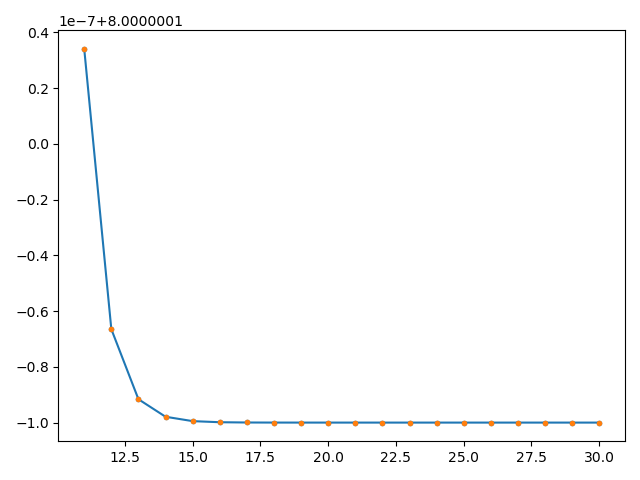

In [42]:
fig, ax = plt.subplots()

ax.plot(N_values,  ΔE_vs_N , '.-')
ax.plot(N_values,  ΔE_vs_N_analytic , '.')  
# ax.set_yscale('log')

fig.tight_layout()

In [43]:
ΔE_vs_N_analytic/ΔE_vs_N

array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

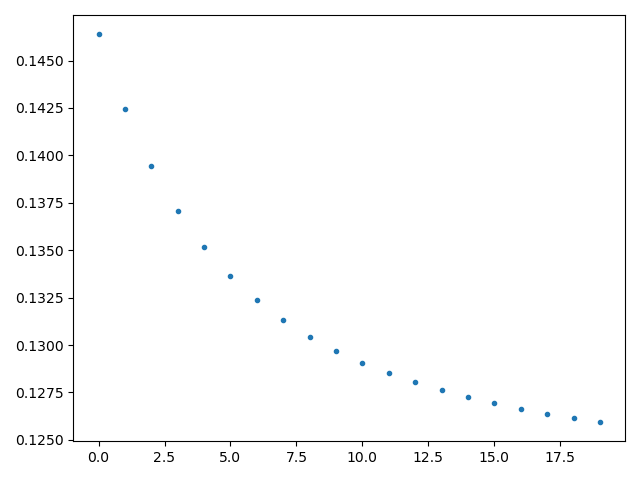

In [44]:
fig, ax = plt.subplots()

ax.plot(ΔE_bulk_vs_N,'.')

fig.tight_layout()

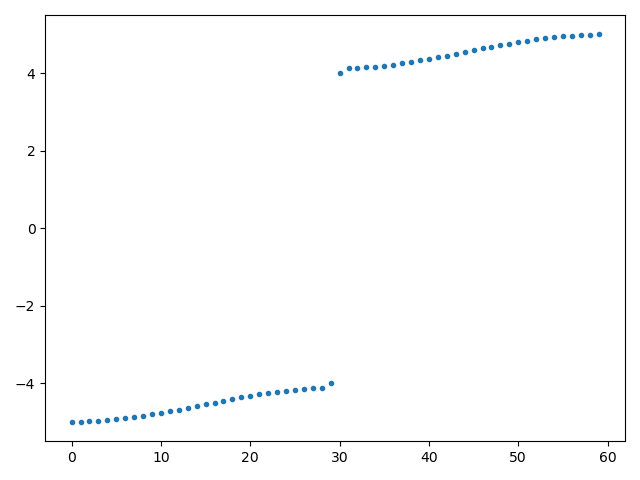

In [45]:
fig, ax = plt.subplots()

ax.plot(E,'.')

fig.tight_layout()

In [46]:
idx = -1
r = (λ) **2
N0 =  2 * np.sqrt( (1-r**N_values[idx]) / (1-r)  ) * np.sqrt(2)**-1
N0

1.6329931618554518

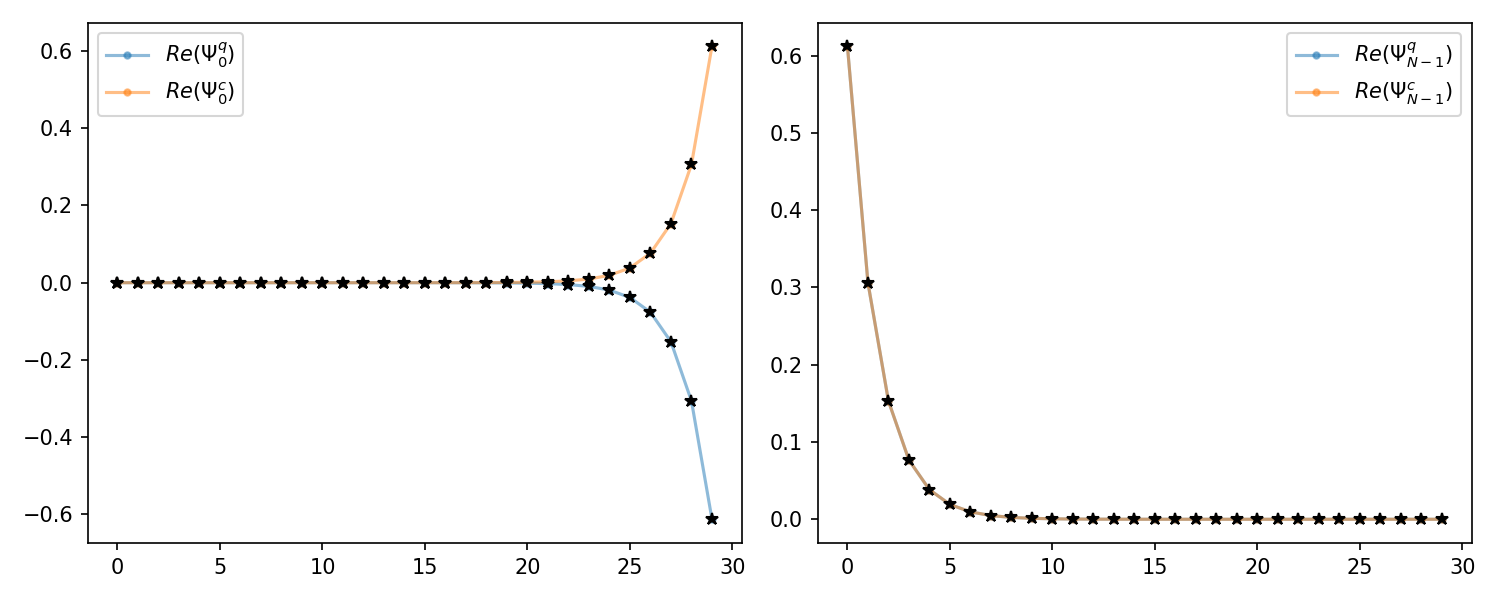

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[10,4], dpi=150)

ax1.plot(np.real(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_0^q)$', alpha=0.5)
ax1.plot(np.real(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_0^c)$', alpha=0.5)
# ax1.plot(np.imag(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_0^q)$', alpha=0.5)
# ax1.plot(np.imag(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_0^c)$', alpha=0.5)

ax1.plot(np.arange(N_values[idx]),  1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*k')
ax1.plot(np.arange(N_values[idx]), -1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*k')
# ax1.set_yscale('log')

ax2.plot(np.real(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_{N-1}^q)$', alpha=0.5)
ax2.plot(np.real(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_{N-1}^c)$', alpha=0.5)

ax2.plot(np.arange(N_values[idx]),  1/N0   * λ ** np.arange(N_values[idx]), '*k')

# ax2.plot(np.imag(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_{N-1}^q)$', alpha=0.5)
# ax2.plot(np.imag(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_{N-1}^c)$', alpha=0.5)

ax1.legend()
ax2.legend()
fig.tight_layout()

In [48]:
np.real(Ψ_right_vs_N[idx][0::2]) / ( 1/N0   * λ ** np.arange(N_values[idx]) )

array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9997, 0.9987, 0.9946, 0.9785, 0.9141, 0.6562])

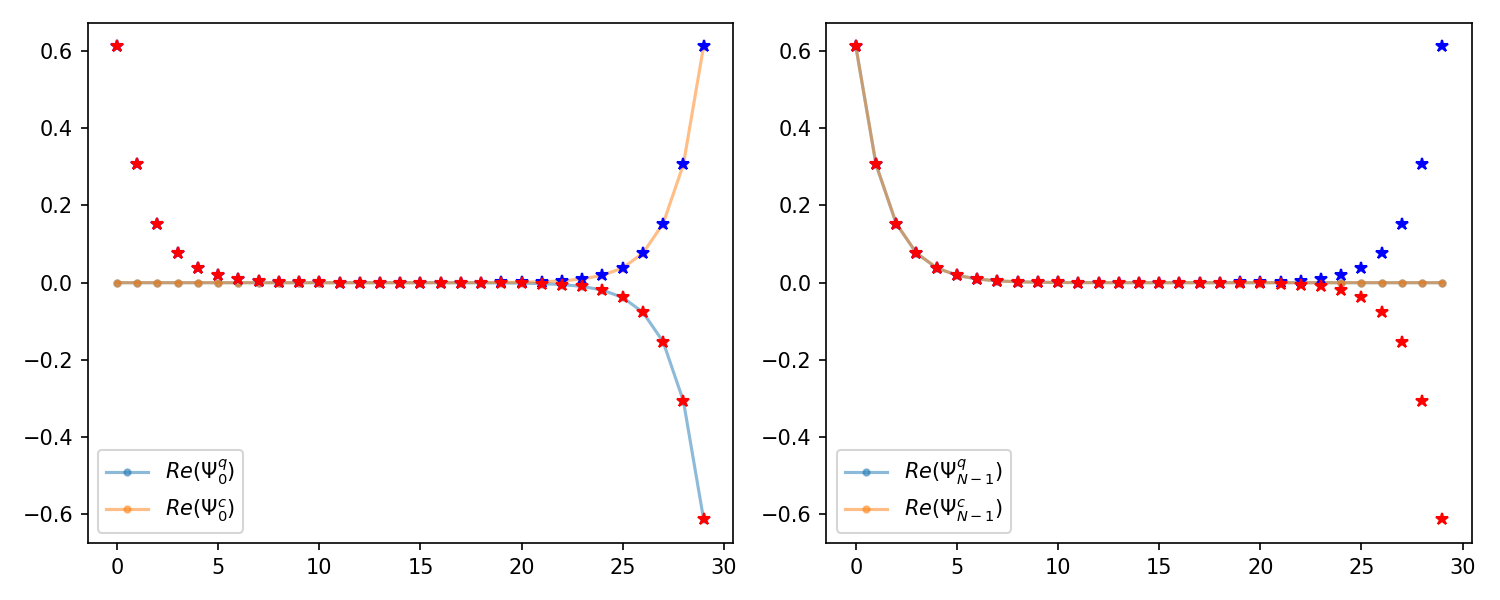

In [49]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[10,4], dpi=150)

ax1.plot(np.real(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_0^q)$', alpha=0.5)
ax1.plot(np.real(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_0^c)$', alpha=0.5)
# ax1.plot(np.imag(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_0^q)$', alpha=0.5)
# ax1.plot(np.imag(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_0^c)$', alpha=0.5)

ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) + 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*b')
ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) - 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*r')

ax2.plot(np.real(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_{N-1}^q)$', alpha=0.5)
ax2.plot(np.real(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_{N-1}^c)$', alpha=0.5)
# ax2.plot(np.imag(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_{N-1}^q)$', alpha=0.5)
# ax2.plot(np.imag(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_{N-1}^c)$', alpha=0.5)

ax2.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) + 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*b')
ax2.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) - 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*r')

ax1.legend()
ax2.legend()
fig.tight_layout()

In [50]:
1/N0   * (λ ** np.arange(N_values[idx]) +  λ ** (N_values[idx]-1-np.arange(N_values[idx]))) / np.real(Ψ_right_vs_N[idx][0::2])

array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0001, 1.0005, 1.0020, 1.0078, 1.0313, 1.1250, 1.5000, 3.0000, 9.0000, 33.0000, 129.0000, 513.0002, 2049.0027, 8193.0430, 32769.6875, 131084.0010, 524465.0594, 2099972.7877, 8433908.3122, 34291157.0779, 146836489.8466,
       818089010.2884])

## Analytical solution for $g_\Phi =0 $ and $g_q=(1+\gamma)g_c$

In [51]:
δ, g_Φ, g_c, g_q = cases[1]
γ = 0.1
g_q = (1+γ) * g_c

In [52]:

ω_0=0
ω_c = ω_0 - δ/2 # Onsite frequency for mode a (resonator)
ω_q = ω_0 + δ/2 # Onsite frequency for mode b (qubit)

N_values = np.linspace(11,100,20,dtype='int')
ΔE_vs_N = np.zeros(len(N_values))
Ψ_left_vs_N = []
Ψ_right_vs_N = []

for i, N in enumerate(N_values):
    H_real = cm.real_H_unit_cell_boson_ladder(ω_c, ω_q, g_Φ, g_c, g_q, N)
    
    E, Ψ = np.linalg.eigh(H_real)
    sorted_indices = np.argsort(np.real(E))
    E = E[sorted_indices]
    Ψ = Ψ[:,sorted_indices]
    ΔE_vs_N[i] = E[N]-E[N-1]
    Ψ_left_vs_N .append(Ψ[:,N-1])
    Ψ_right_vs_N.append(Ψ[:,N])


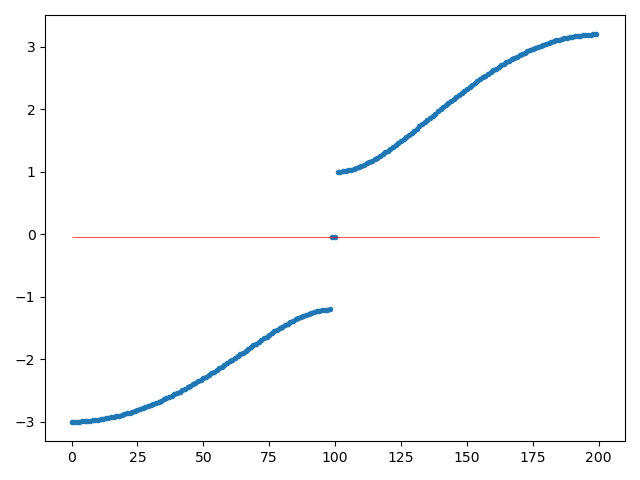

In [53]:
E_eig = δ/2 * (g_c-g_q)/(g_c+g_q)

fig, ax = plt.subplots()

ax.plot(E,'.')
ax.hlines(E_eig,0,2*N_values[-1],'r', linewidth=0.5)

# ax.set_ylim(-0.075,-0.025)

fig.tight_layout()

In [54]:
g_eff = 2*(g_c + g_q)
λ = δ / g_eff
ΔE_vs_N_analytic =  g_eff * (1-λ**2) * λ **(N_values)  / (1-λ**(2*N_values) )
# ε = g_eff * (1-λ**2) * λ **(N_values)  / (1-λ**(2*N_values) )
# ΔE_vs_N_analytic = np.sqrt(E_eig**2+ε**2)
λ

0.47619047619047616

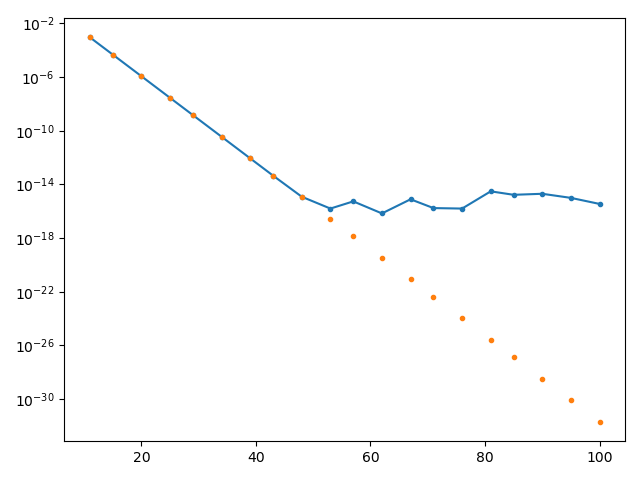

In [55]:
fig, ax = plt.subplots()

ax.plot(N_values,  ΔE_vs_N , '.-')
ax.plot(N_values,  ΔE_vs_N_analytic , '.')  
ax.set_yscale('log')

fig.tight_layout()

In [56]:
ΔE_vs_N_analytic/ΔE_vs_N

array([1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 1.0017, 0.9135, 0.1702, 0.0025, 0.0005, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [57]:
idx = -1
# N0 = 1/ np.sqrt( (1-λ**2) / ((1-λ**(2*N_values[idx]))*(1+g_c/g_q)) )
N0 =  np.sqrt( (1-λ**(2*N_values[idx]))*(1+g_c/g_q) / (1-λ**2)  )

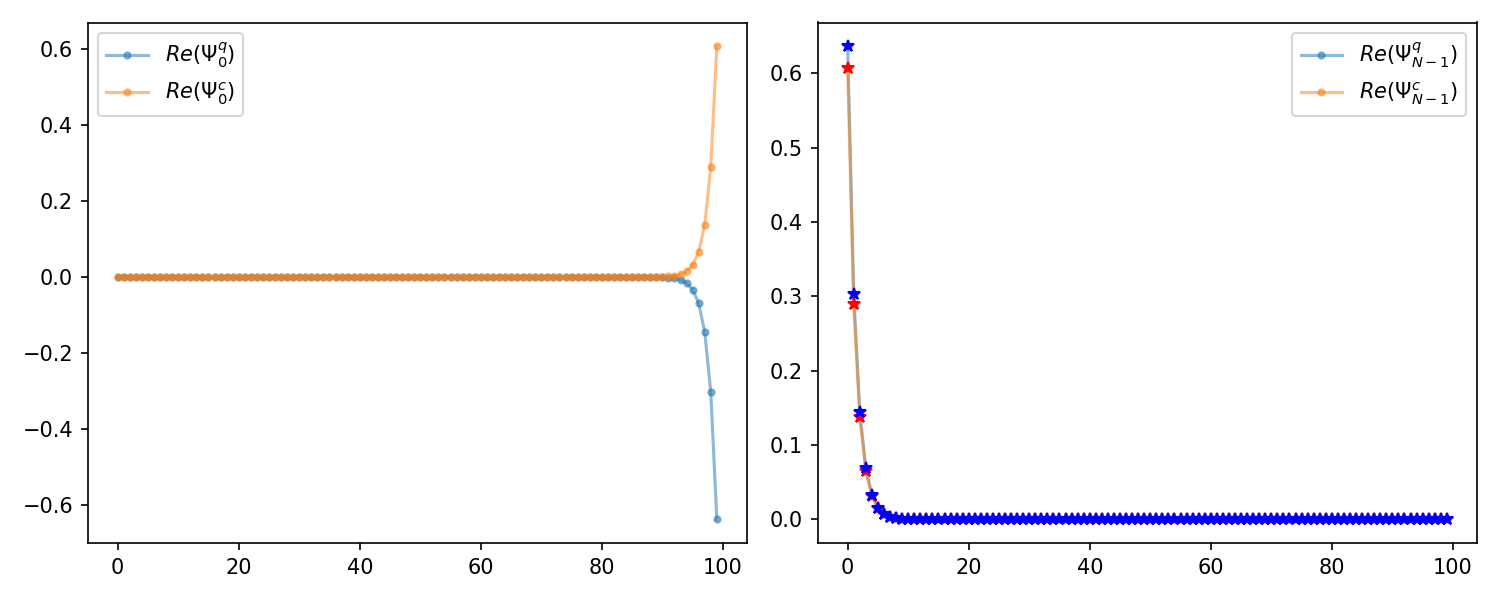

In [58]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[10,4], dpi=150)

ax1.plot(np.real(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_0^q)$', alpha=0.5)
ax1.plot(np.real(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_0^c)$', alpha=0.5)
# ax1.plot(np.imag(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_0^q)$', alpha=0.5)
# ax1.plot(np.imag(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_0^c)$', alpha=0.5)

# ax1.plot(np.arange(N_values[idx]),  1/N0 * np.sqrt(g_c/g_q)  * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*r')
# ax1.plot(np.arange(N_values[idx]), -1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*b')

ax2.plot(np.real(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_{N-1}^q)$', alpha=0.5)
ax2.plot(np.real(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_{N-1}^c)$', alpha=0.5)

ax2.plot(np.arange(N_values[idx]),  1/N0  * np.sqrt(g_c/g_q) * λ ** np.arange(N_values[idx]), '*r')
ax2.plot(np.arange(N_values[idx]),  1/N0 *    λ ** np.arange(N_values[idx]), '*b')
# ax2.set_yscale('log')

# ax2.plot(np.imag(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_{N-1}^q)$', alpha=0.5)
# ax2.plot(np.imag(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_{N-1}^c)$', alpha=0.5)

ax1.legend()
ax2.legend()
fig.tight_layout() 

In [59]:
np.real(Ψ_right_vs_N[idx][0::2]) / (1/N0   * λ ** np.arange(N_values[idx]) )

array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
       1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0001, 1.0002, 1.0003, 1.0007, 1.0019, 1.0003, 1.0233, 1.0404, 0.9930, 0.8400, 0.3190, -1.0648, -0.9888, 1.2184, -0.5041, 0.1182, -0.0184, 0.0021, -0.0002, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000,
       -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000])

In [60]:
np.real(Ψ_right_vs_N[idx][1::2]) / (1/N0 *np.sqrt(g_c/g_q)  * λ ** np.arange(N_values[idx]) )

array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
       1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 1.0011, 0.9967, 0.9546, 0.8889, 0.8979, 1.1279, 1.0324, -3.8072, 2.6013, -0.8853, 0.1870, -0.0272, 0.0029, -0.0002, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000,
       -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000, 0.0000, -0.0000])

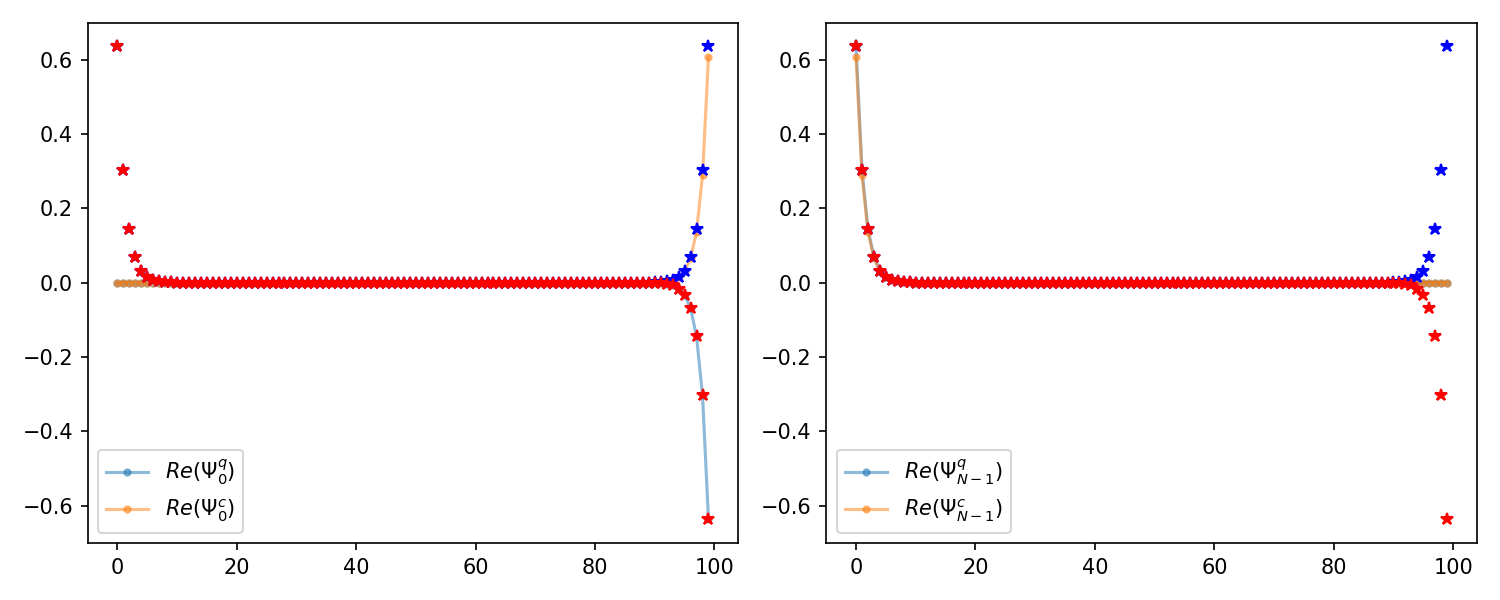

In [61]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[10,4], dpi=150)

ax1.plot(np.real(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_0^q)$', alpha=0.5)
ax1.plot(np.real(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_0^c)$', alpha=0.5)
# ax1.plot(np.imag(Ψ_left_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_0^q)$', alpha=0.5)
# ax1.plot(np.imag(Ψ_left_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_0^c)$', alpha=0.5)

ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) + 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*b')
ax1.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) - 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*r')

ax2.plot(np.real(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Re(\Psi_{N-1}^q)$', alpha=0.5)
ax2.plot(np.real(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Re(\Psi_{N-1}^c)$', alpha=0.5)
# ax2.plot(np.imag(Ψ_right_vs_N[idx][0::2]),'.-', label=r'$Im(\Psi_{N-1}^q)$', alpha=0.5)
# ax2.plot(np.imag(Ψ_right_vs_N[idx][1::2]),'.-', label=r'$Im(\Psi_{N-1}^c)$', alpha=0.5)

ax2.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) + 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*b')
ax2.plot(np.arange(N_values[idx]),1/N0   * λ ** np.arange(N_values[idx]) - 1/N0   * λ ** (N_values[idx]-1-np.arange(N_values[idx])) , '*r')

ax1.legend()
ax2.legend()
fig.tight_layout()

In [62]:
1/N0   * (λ ** np.arange(N_values[idx]) +  λ ** (N_values[idx]-1-np.arange(N_values[idx]))) / np.real(Ψ_right_vs_N[idx][0::2])

array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
       1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9997, 0.9996, 0.9994, 1.0053, 1.0012, 1.0649, 1.4866, 3.6904, 32.1677, -39.2938, -183.1692, 652.7507, -6950.2782, 130655.7571, -3700968.2996, 145671680.9859, -7573867279.7380, 502194909498.4730, -41374465681607.1328,
       4151090211223999.0000, -499121677196448832.0000, 70991221261801406464.0000, -11816086004885039874048.0000, 2280818344856591343288320.0000, -506687114414207602933104640.0000, 128706341952556059923784400896.0000, -37175863241257844738079569477632.0000, 12152378577254555451126445930184704.0000,
       -4477525735732291635659525376977141760.0000, 1853065057478948732755070521770080468992.0000, -85891616883862325854141

## Controling the BICs with $\varphi_{ext}$

In [63]:
δ, g_Φ, g_c, g_q = cases[1]
g_Φ = 10
g_φ = 1
g_c = 0.25
g_q = 0.25
δφ_ext_values = np.linspace(0,2,100) 
N=10

In [64]:

ω_c = 4
ω_q = 4

ω_0=ω_c + ω_q

E_vs_δφ_ext             = np.zeros([len(δφ_ext_values), 2*N])
ΔE_bound_vs_δφ_ext      = np.zeros(len(δφ_ext_values))
ΔE_k_vs_δφ_ext          = np.zeros(len(δφ_ext_values))
ΔE_left_bulk_vs_δφ_ext  = np.zeros(len(δφ_ext_values))
ΔE_right_bulk_vs_δφ_ext = np.zeros(len(δφ_ext_values))

δ_vs_δφ_ext = np.zeros(len(δφ_ext_values))
cos_θ_vs_δφ_ext = np.zeros(len(δφ_ext_values))

for i, δφ_ext in enumerate(δφ_ext_values):
    ω_q_new = np.sqrt(ω_q**2 + 4 * g_φ**2 * δφ_ext**2)
    δ = ω_c-ω_q_new
    δ_vs_δφ_ext[i] = δ
    # ω_c = ω_0 - δ/2 # Onsite frequency for mode a (resonator)
    # ω_q = ω_0 + δ/2 # Onsite frequency for mode b (qubit)
    cos_θ = ω_q / ω_q_new
    cos_θ_vs_δφ_ext[i] = cos_θ
    H_real = cm.real_H_unit_cell_boson_ladder(ω_c, ω_q_new, g_Φ * cos_θ, g_c, g_q, N)

    E, _ = np.linalg.eigh(H_real)
    sorted_indices = np.argsort(np.real(E))
    E = E[sorted_indices]
    
    ΔE_bound_vs_δφ_ext[i] =  E[N]-E[N-1]
    ΔE_left_bulk_vs_δφ_ext[i]  =  E[N+1]-E[N]
    ΔE_right_bulk_vs_δφ_ext[i] =  E[N-1]-E[N-2]
    ΔE_k_vs_δφ_ext[i] = E[N+1]-E[N-2]
    E_vs_δφ_ext[i] = E

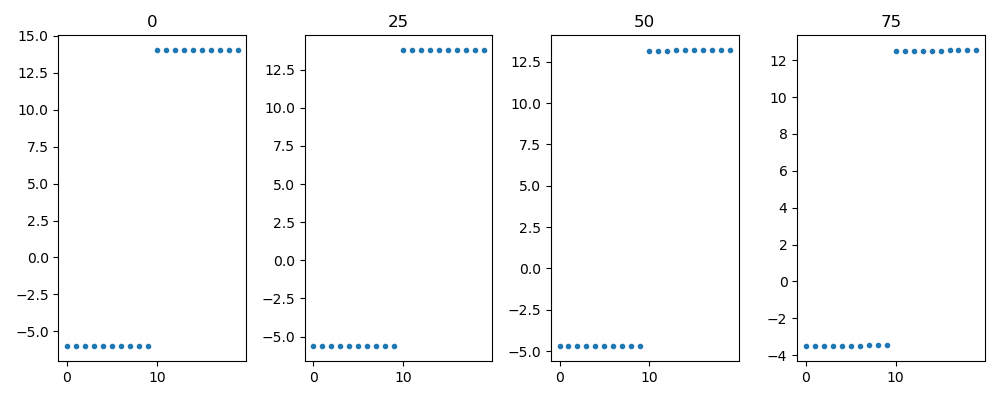

In [65]:
fig, axs = plt.subplots(ncols=4, figsize=[10,4])

for i, ax in enumerate(axs):
    ax.plot(E_vs_δφ_ext[i*len(δφ_ext_values)//len(axs)],'.')
    ax.set_title(f'{i*len(δφ_ext_values)//len(axs)}')
    # ax.set_ylim([3,6])
fig.tight_layout()

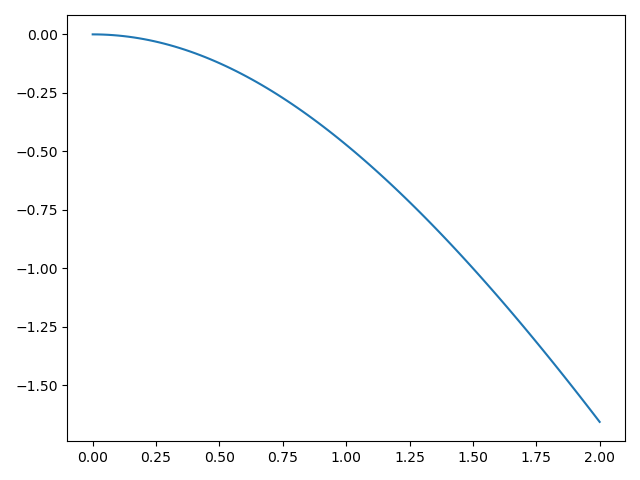

In [66]:
fig, ax = plt.subplots()

ax.plot(δφ_ext_values, δ_vs_δφ_ext)
# ax.plot(δφ_ext_values, cos_θ_vs_δφ_ext)

fig.tight_layout()

In [67]:
ΔE_k_analytic_vs_δφ_ext = np.zeros(len(δφ_ext_values))
ΔE_bound_analytic_vs_δφ_ext = np.zeros(len(δφ_ext_values))
for i, δφ_ext in enumerate(δφ_ext_values):
    ω_q_new = np.sqrt(ω_q**2 + 4 * g_φ**2 * δφ_ext**2)
    δ = ω_c-ω_q_new
    cos_θ = ω_q / ω_q_new
    
    
    ΔE_k_analytic_vs_δφ_ext[i] = 2 * np.sqrt(-2*np.abs(δ)*g_c + δ**2/4 + 4 * g_c**2 + cos_θ**2 * g_Φ**2)
    
    
    g_eff = 2*(g_c + g_q)
    λ = δ / g_eff
    
    ε = 2 * g_c * (1-λ**2) * λ**N / (1-λ**(2*N) )
    
    ΔE_bound_analytic_vs_δφ_ext[i] = 2 * np.sqrt( ε**2 + cos_θ**2 * g_Φ**2)
    

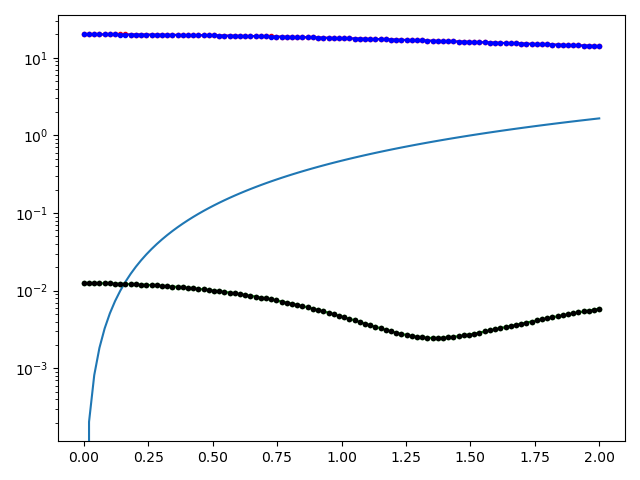

In [68]:
fig, ax = plt.subplots()

ax.plot(δφ_ext_values, np.abs(δ_vs_δφ_ext))


ax.plot(δφ_ext_values, ΔE_k_vs_δφ_ext,'r')
ax.plot(δφ_ext_values, ΔE_k_analytic_vs_δφ_ext,'.r')

ax.plot(δφ_ext_values, ΔE_bound_vs_δφ_ext,'b')
ax.plot(δφ_ext_values, ΔE_bound_analytic_vs_δφ_ext,'.b')


ax.plot(δφ_ext_values, ΔE_left_bulk_vs_δφ_ext, 'g')
ax.plot(δφ_ext_values, ΔE_right_bulk_vs_δφ_ext,'.g')


ax.plot(δφ_ext_values, np.abs((ΔE_k_vs_δφ_ext-ΔE_bound_vs_δφ_ext)/2),'.k')


# ax.vlines(np.sqrt(ω_c**2-ω_q**2)/(2*g_φ), 0, 3.5)

ax.set_yscale('log')
fig.tight_layout()

# Phase diagram

In [69]:
g_c=1
g_q=1
G=g_c+g_q
δ=np.linspace(-4,4,201)
λ=np.abs(δ)/(2*G)
ε = 1/np.abs(np.log(λ))
N=10
ΔE_edge =  2*G * (1-λ**2) * λ **N  / (1-λ**(2*N) )
ΔE_bulk = 2*np.sqrt(np.abs(δ)*G+δ**2/4+4*(g_c*g_q) )


C:\Users\gabri\AppData\Local\Temp\ipykernel_28572\648201554.py:6: RuntimeWarning: divide by zero encountered in log
  ε = 1/np.abs(np.log(λ))
C:\Users\gabri\AppData\Local\Temp\ipykernel_28572\648201554.py:6: RuntimeWarning: divide by zero encountered in divide
  ε = 1/np.abs(np.log(λ))
C:\Users\gabri\AppData\Local\Temp\ipykernel_28572\648201554.py:8: RuntimeWarning: invalid value encountered in divide
  ΔE_edge =  2*G * (1-λ**2) * λ **N  / (1-λ**(2*N) )


C:\Users\gabri\AppData\Local\Temp\ipykernel_28572\2807289594.py:4: RuntimeWarning: divide by zero encountered in log
  ax.plot(δ/(2*G), np.log(ε))


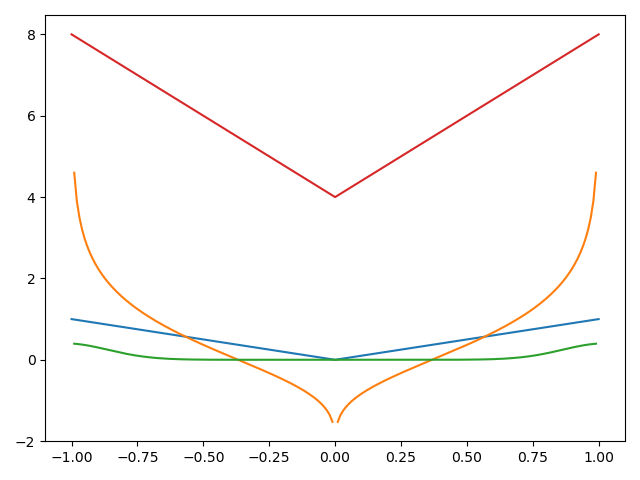

In [70]:
fig, ax = plt.subplots()

ax.plot(δ/(2*G), λ)
ax.plot(δ/(2*G), np.log(ε))
ax.plot(δ/(2*G), ΔE_edge)
ax.plot(δ/(2*G), ΔE_bulk)

fig.tight_layout()